In [1]:
!pip install openai
!pip install tiktoken

In [ ]:
import pandas as pd
import numpy as np
import html
import re
import os
import json
import openai
import time
import tiktoken
from collections import defaultdict, Counter
from pydantic import BaseModel
from typing import List, Dict, Tuple, Set
from tqdm import tqdm  # For progress tracking
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
from operator import itemgetter

In [ ]:
#1.Process Data

# function to extract sentences and annotations
def extract_data(text):
    data = []
    sentences = text.strip().split('\n')
    for sentence in sentences:
        parts = sentence.split('|')
        if len(parts) < 2:  # Ensure valid format
            continue  # Skip invalid lines
        text = parts[0].strip()
        annotations = [part.strip() for part in parts[1:]]
        data.append({'text': text, 'annotations': annotations})
    return data

# function to read and process a file
def process_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        return extract_data(text)
    except FileNotFoundError:
        print(f"Warning: File {file_path} not found.")
        return []
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return []

# Process train.txt
train_data = process_file('train.txt')
df_train = pd.DataFrame(train_data) if train_data else pd.DataFrame()
if not df_train.empty:
    print("\nTRAIN DATA:")
    pd.set_option('display.max_colwidth', None)
    print(df_train.head())
else:
    print("No data extracted from train.txt")

# Process dev.txt
dev_data = process_file('dev.txt')
df_dev = pd.DataFrame(dev_data) if dev_data else pd.DataFrame()
if not df_dev.empty:
    print("\nDEV DATA:")
    print(df_dev.head())
else:
    print("No data extracted from dev.txt")

# Process test.txt
test_data = process_file('test.txt')
df_test = pd.DataFrame(test_data) if test_data else pd.DataFrame()
if not df_test.empty:
    print("\nTEST DATA:")
    print(df_test.head())
else:
    print("No data extracted from test.txt")

# Three separate DataFrames:
# df_train - containing training data
# df_dev - containing development/validation data
# df_test - containing test data


TRAIN DATA:
                                                                                                                                                                                                                                text  \
0              NEW YORK (Reuters) - Apple Inc Chief Executive Steve Jobs sought to soothe investor concerns about his health on Monday, saying his weight loss was caused by a hormone imbalance that is relatively simple to treat.   
1                                                          Last week, Citigroup Inc's ( C.N ) Chief Executive Vikram Pandit said that he, Chairman Win Bischoff, and senior adviser Robert Rubin would not receive bonuses for 2008.   
2                                                             Lehman Brothers LEH.N shares fell sharply on Monday on speculation that the investment bank could be bought for $15 a share, a price well below current market levels.   
3  Franz told Reuters that Fiat Chief Executive Sergio Marc

In [ ]:
# Data Preprocessing

# Clean text
def clean_text(text):
    """
    Clean text by:
    1. Decoding HTML entities (like &#039; &#959; etc.)
    2. Removing HTML tags (like <p> </p>)
    """
    if not isinstance(text, str):
        return text

    # Decode HTML entities (converts &#039; to ', &#959; to ο, etc.)
    text = html.unescape(text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Replace Unicode right single quotation mark with a standard single quote
    text = text.replace('\u2019', "'")
    
    return text

# Apply cleaning to the 'text' column in all three dataframes
for df in [df_train, df_dev, df_test]:
    if not df.empty and 'text' in df.columns:
        df['text'] = df['text'].apply(clean_text)

print(df_train.iloc[2069])
df_train
df_test

text           New 'Bratz' more Taylor Swift than Britney: CEO Ashley Holt, CNBC CNBC.com SHARES Bratz makeover no child's play: CEO Isaac Larian, MGA Entertainment CEO, discusses the relaunch of the Bratz dolls and its battle to take on Mattel's Barbie.
annotations                                                                                                                                                                                                              [Bratz ; MGA Entertainment ; creator]
Name: 2069, dtype: object


,text,annotations
0,"Wednesday, July 8, 2015 10:30AM IST (5:00AM GMT) Rimini Street Comment on Oracle Litigation Las Vegas, United States Rimini Street, Inc., the leading independent provider of enterprise software support for SAP AG's (NYSE:SAP) Business Suite and BusinessObjects software and Oracle Corporation's (NYSE:ORCL) Siebel , PeopleSoft , JD Edwards , E-Business Suite , Oracle Database , Hyperion and Oracle Retail software, today issued a statement on the Oracle litigation.",[PeopleSoft ; JD Edwards ; subsidiary]
1,"The Daily Show with Trevor Noah premieres tonight... and while the show will be based on Comedy Central, Viacom pans to simulcast the debut across all of its networks, including VH1 and MTV.",[VH1 ; Viacom ; owned_by]
2,"""Our results for the quarter show very balanced performance across our business lines,"" said Citigroup chief executive Michael Corbat in a statement.",[Michael Corbat ; Citigroup ; employer]
3,"Saudi Arabian budget carrier flynas, which made its first profit this year, is in talks with plane manufacturers Airbus and Boeing as it seeks to purchase four new aircraft over the next four years, its chief executive told reporters.",[Airbus ; aircraft ; product_or_material_produced]
4,"First Eagle is currently owned by members of the Arnhold family, private equity firm TA Associates Management and employees.",[TA Associates ; private equity ; industry]
...,...,...
1063,"In this regard, adding features for forex traders, Thomson Reuters has announced the launch of a data visualization offering for currencies that is being made available for free to users of the Thomson Reuters Eikon platform.","[Thomson Reuters ; Reuters ; subsidiary, Thomson Reuters ; Reuters ; business_division]"
1064,"However, after initially rising and helping to lift the Nasdaq in the wake of an Oppenheimer & Co upgrade, shares of Apple Inc ( AAPL.O ) retreated as its performance at the Macworld expo in San Francisco disappointed investors.",[Apple Inc ; NASDAQ ; stock_exchange]
1065,"July 16 (Reuters) - Wall Street rose on Thursday, with the Nasdaq up 1 percent near a record high after eBay and Netflix reported strong quarterly results.",[eBay ; NASDAQ ; stock_exchange]
1066,"BWise is a Nasdaq fully-owned company and positioned by independent analysts such as Forrester , Gartner and Chartis as a leader in enterprise GRC platforms.",[Forrester ; NASDAQ ; stock_exchange]


In [ ]:
# Clean sources' information
def clean_source_info(text):
    """
    Clean source information from the beginning of text.
    Looks for specific patterns in the first 50 characters and removes everything
    from the beginning to the end of the matched pattern.
    """
    if not isinstance(text, str):
        return text

    # Check only the first 50 characters (or all if less than 50)
    first_part = text[:50] if len(text) > 50 else text

    # Patterns to look for in the beginning
    patterns = [
        r'\(AP\) -+ ',
        r'\(AP\) _ ',
        r'\(AP\) — ',
        r'\(IANS\) ',
        r'\(Reuters\) - ',
        r'\(TheStreet\) -- ',
        r'\(GLOBE NEWSWIRE\) -- ',
        r'\(ShareCast\) - \(ShareCast News\) - ',
        r'CNBC CNBC\.com SHARES ',
        r'BST - '
    ]

    # Find the earliest match of any pattern
    earliest_match = None
    earliest_end = len(text)

    for pattern in patterns:
        match = re.search(pattern, first_part)
        if match and match.end() < earliest_end:
            earliest_match = match
            earliest_end = match.end()

    # If a match was found, remove everything up to the end of the match
    if earliest_match:
        return text[earliest_end:].strip()

    return text


def clean_source_info_2(text):
    """
    Cleans a text string based on the presence of " IST " and "|"
    """
    try:
        ist_index = text.find(" IST ")
        if ist_index != -1:
            pipe_index = text.rfind("|", 0, ist_index)  # Search backward for "|"

            if pipe_index != -1:
                return text[:pipe_index].strip() + text[ist_index + len(" IST "):].strip()
            else:
                return text[ist_index + len(" IST "):].strip()
        return text  # Return original text if " IST " is not found
    except AttributeError:
        return text  # Handle cases where the input might not be a string

# Apply cleaning to the 'text' column in all three dataframes
for df in [df_train, df_dev, df_test]:
    if not df.empty and 'text' in df.columns:
        df['text'] = df['text'].apply(clean_source_info)

for df in [df_train, df_dev, df_test]:
    if not df.empty and 'text' in df.columns:
        df['text'] = df['text'].apply(clean_source_info_2)


print(df_train.iloc[2119])
df_dev

text           Oil and gas explorer Roxi Petroleum (Other OTC: ROXIF - news ) has reached an agreement to cancel royalty payments from its flagship asset.
annotations                                                                 [ROXI ; London ; location_of_formation, ROXI ; London ; headquarters_location]
Name: 2119, dtype: object


,text,annotations
0,"Yum China will become a franchise of Yum Brands in Mainland China, the parent of KFC, Pizza Hut and Taco Bell chains said.","[Yum China ; Pizza Hut ; brand, Yum China ; Taco Bell ; brand, Yum Brands ; Taco Bell ; subsidiary, Yum Brands ; Taco Bell ; owner_of, Yum Brands ; Pizza Hut ; subsidiary, Yum Brands ; Pizza Hut ; owner_of]"
1,Warren Buffett's Berkshire Hathaway (Sao Paolo: BERK34F.SA - news ) this month also launched its first cyber policies through its specialty insurance division.,[Berkshire Hathaway ; insurance ; industry]
2,"In the wake of last year's attack on Sony Pictures Entertainment, parent Sony Corp said its financial condition could suffer if it were attacked again, since current policies ""might not cover all expenses and losses.""","[Sony Pictures ; Sony ; owned_by, Sony ; Sony Pictures ; owner_of, Sony Pictures ; Sony ; founded_by, Sony Pictures ; Sony ; parent_organization, Sony ; Sony Pictures ; subsidiary]"
3,"Oct 12 Investment bank Cantor Fitzgerald Europe, part of Cantor Fitzgerald, has hired four executives from financial services firm Shore Capital for its Edinburgh office.","[Cantor Fitzgerald ; financial services ; industry, Cantor Fitzgerald ; financial services ; product_or_material_produced]"
4,"Collaborating with University of Connecticut doctoral student Devon Goss, Matthew Hughey researched nearly 24,000 English-language newspaper articles across the globe from 2003-2014.",[Matthew Hughey ; University of Connecticut ; employer]
...,...,...
1002,UK Markets close in 8 hrs 9 mins Barclays Sacks Chief Executive Antony Jenkins,[Antony Jenkins ; Barclays ; employer]
1003,Fans of Gilmore Girls around the country likely squealed in delight after reports surfaced on Monday that Netflix is in negotiations to revive the popular TV show .,[Gilmore Girls ; Netflix ; distributed_by]
1004,"Gilmore Girls joins a handful of other shows that went off the air only to be revived by Netflix or, increasingly, network TV.",[Gilmore Girls ; Netflix ; distributed_by]
1005,So we're excited to have Cobra Kai in the Netflix family.,[Cobra Kai ; Netflix ; distributed_by]


In [ ]:
# Clean tickers
def remove_parenthetical_expressions(text):
    """
    Remove all text within parentheses () and square brackets []
    from the given text.
    """
    if not isinstance(text, str):
        return text

    # Remove text within parentheses ()
    text = re.sub(r'\([^)]*\)', '', text)

    # Remove text within square brackets []
    text = re.sub(r'\[[^\]]*\]', '', text)

    # Clean up any double spaces created by the removals
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning to the 'text' column in all three dataframes
for df in [df_train, df_dev, df_test]:
    if not df.empty and 'text' in df.columns:
        df['text'] = df['text'].apply(remove_parenthetical_expressions)

print(df_train.iloc[2127])
df_dev

text           Chemicals group Elementis saw its first half pre-tax profit decline, as its oil and gas related and businesses reported a drop in sales.
annotations                                                                                                [Elementis ; London ; headquarters_location]
Name: 2127, dtype: object


,text,annotations
0,"Yum China will become a franchise of Yum Brands in Mainland China, the parent of KFC, Pizza Hut and Taco Bell chains said.","[Yum China ; Pizza Hut ; brand, Yum China ; Taco Bell ; brand, Yum Brands ; Taco Bell ; subsidiary, Yum Brands ; Taco Bell ; owner_of, Yum Brands ; Pizza Hut ; subsidiary, Yum Brands ; Pizza Hut ; owner_of]"
1,Warren Buffett's Berkshire Hathaway this month also launched its first cyber policies through its specialty insurance division.,[Berkshire Hathaway ; insurance ; industry]
2,"In the wake of last year's attack on Sony Pictures Entertainment, parent Sony Corp said its financial condition could suffer if it were attacked again, since current policies ""might not cover all expenses and losses.""","[Sony Pictures ; Sony ; owned_by, Sony ; Sony Pictures ; owner_of, Sony Pictures ; Sony ; founded_by, Sony Pictures ; Sony ; parent_organization, Sony ; Sony Pictures ; subsidiary]"
3,"Oct 12 Investment bank Cantor Fitzgerald Europe, part of Cantor Fitzgerald, has hired four executives from financial services firm Shore Capital for its Edinburgh office.","[Cantor Fitzgerald ; financial services ; industry, Cantor Fitzgerald ; financial services ; product_or_material_produced]"
4,"Collaborating with University of Connecticut doctoral student Devon Goss, Matthew Hughey researched nearly 24,000 English-language newspaper articles across the globe from 2003-2014.",[Matthew Hughey ; University of Connecticut ; employer]
...,...,...
1002,UK Markets close in 8 hrs 9 mins Barclays Sacks Chief Executive Antony Jenkins,[Antony Jenkins ; Barclays ; employer]
1003,Fans of Gilmore Girls around the country likely squealed in delight after reports surfaced on Monday that Netflix is in negotiations to revive the popular TV show .,[Gilmore Girls ; Netflix ; distributed_by]
1004,"Gilmore Girls joins a handful of other shows that went off the air only to be revived by Netflix or, increasingly, network TV.",[Gilmore Girls ; Netflix ; distributed_by]
1005,So we're excited to have Cobra Kai in the Netflix family.,[Cobra Kai ; Netflix ; distributed_by]


In [ ]:
# Clean other soucres' location
def clean_location_dash(text):
    """
    Clean location information from the beginning of text.
    Looks for "WORD - " pattern in the first 50 characters and
    removes everything from the beginning to the end of the matched pattern.
    """
    if not isinstance(text, str):
        return text

    # Check only the first 50 characters (or all if less than 50)
    first_part = text[:50] if len(text) > 50 else text

    # Pattern to look for location followed by dash: word(s) followed by " - "
    # This will match patterns like "DUBLIN - ", "NEW YORK - ", etc.
    pattern = r'^\w+(\s+\w+)* - '

    match = re.search(pattern, first_part)
    if match:
        return text[match.end():].strip()

    return text

# Apply cleaning to the 'text' column in all three dataframes
for df in [df_train, df_dev, df_test]:
    if not df.empty and 'text' in df.columns:
        df['text'] = df['text'].apply(clean_location_dash)

print(df_train.iloc[5])
df_dev

text           CBS did not disclose details of the agreement, but it comes just days after its sister company Viacom Inc threatened to pull its cable channels from Time Warner's 13 million homes because of a disagreement over a separate deal.
annotations                                                                                                                                               [Viacom ; CBS ; owned_by, Viacom ; CBS ; subsidiary, Viacom ; CBS ; parent_organization]
Name: 5, dtype: object


,text,annotations
0,"Yum China will become a franchise of Yum Brands in Mainland China, the parent of KFC, Pizza Hut and Taco Bell chains said.","[Yum China ; Pizza Hut ; brand, Yum China ; Taco Bell ; brand, Yum Brands ; Taco Bell ; subsidiary, Yum Brands ; Taco Bell ; owner_of, Yum Brands ; Pizza Hut ; subsidiary, Yum Brands ; Pizza Hut ; owner_of]"
1,Warren Buffett's Berkshire Hathaway this month also launched its first cyber policies through its specialty insurance division.,[Berkshire Hathaway ; insurance ; industry]
2,"In the wake of last year's attack on Sony Pictures Entertainment, parent Sony Corp said its financial condition could suffer if it were attacked again, since current policies ""might not cover all expenses and losses.""","[Sony Pictures ; Sony ; owned_by, Sony ; Sony Pictures ; owner_of, Sony Pictures ; Sony ; founded_by, Sony Pictures ; Sony ; parent_organization, Sony ; Sony Pictures ; subsidiary]"
3,"Oct 12 Investment bank Cantor Fitzgerald Europe, part of Cantor Fitzgerald, has hired four executives from financial services firm Shore Capital for its Edinburgh office.","[Cantor Fitzgerald ; financial services ; industry, Cantor Fitzgerald ; financial services ; product_or_material_produced]"
4,"Collaborating with University of Connecticut doctoral student Devon Goss, Matthew Hughey researched nearly 24,000 English-language newspaper articles across the globe from 2003-2014.",[Matthew Hughey ; University of Connecticut ; employer]
...,...,...
1002,UK Markets close in 8 hrs 9 mins Barclays Sacks Chief Executive Antony Jenkins,[Antony Jenkins ; Barclays ; employer]
1003,Fans of Gilmore Girls around the country likely squealed in delight after reports surfaced on Monday that Netflix is in negotiations to revive the popular TV show .,[Gilmore Girls ; Netflix ; distributed_by]
1004,"Gilmore Girls joins a handful of other shows that went off the air only to be revived by Netflix or, increasingly, network TV.",[Gilmore Girls ; Netflix ; distributed_by]
1005,So we're excited to have Cobra Kai in the Netflix family.,[Cobra Kai ; Netflix ; distributed_by]


In [8]:
# Load and update relations from the file
with open('relations.txt', 'r') as file:
    relations = [line.replace("product/material produced", "product or material produced")
                     .replace("director/manager", "director or manager")
                 for line in file.read().splitlines()]


# Convert to formatted string
relations_list = ', '.join(f"'{relation}'" for relation in relations)

print(relations_list)  # Check the updated relations

'product or material produced', 'manufacturer', 'distributed by', 'industry', 'position held', 'original broadcaster', 'owned by', 'founded by', 'distribution format', 'headquarters location', 'stock exchange', 'currency', 'parent organization', 'chief executive officer', 'director or manager', 'owner of', 'operator', 'member of', 'employer', 'chairperson', 'platform', 'subsidiary', 'legal form', 'publisher', 'developer', 'brand', 'business division', 'location of formation', 'creator'


In [ ]:
# Clean annotations
def clean_annotations(annotations):
    return [annotation.replace('_', ' ') for annotation in annotations]

# Define the function to parse annotations
def parse_annotation(annotation_str):
    """
    Parse an annotation string in the format "entity1 ; entity2 ; relation"
    Returns a tuple (entity1, entity2, relation) or None if parsing fails
    """
    try:
        parts = annotation_str.split(" ; ")
        if len(parts) == 3:
            entity1, entity2, relation = parts
            return (entity1, entity2, relation)
        return None
    except Exception:
        return None

# Define the directional relationship pairs
relationship_pairs = {
    "product or material produced": "manufacturer",
    "manufacturer": "product or material produced",
    "position held": "chief executive officer",
    "position held": "director or manager",
    "position held": "chairperson",
    "chief executive officer": "position held",
    "director or manager": "position held",
    "chairperson": "position held",
    "owned by": "owner of",
    "owner of": "owned by",
    "parent organization": "subsidiary",
    "subsidiary": "parent organization",
    "creator": "founded by",
    "founded by": "creator"
}

def process_annotations(annotations):
    """
    Process annotations in the given list of annotations.
    This function identifies existing relationships and adds missing reverse relationships.
    """
    existing_relations = set()

    # Extract existing relationships
    for annotation in annotations:
        # Replace "director_/_manager" with "director_or_manager" before parsing
        annotation = annotation.replace("director_/_manager", "director or manager")

        parsed = parse_annotation(annotation)
        if parsed:
            existing_relations.add(parsed)

    # Identify missing reverse relationships
    new_relations = set()
    for entity1, entity2, relation in existing_relations:
        if relation in relationship_pairs:
            reverse_relation = relationship_pairs[relation]
            if (entity2, entity1, reverse_relation) not in existing_relations:
                new_relations.add((entity2, entity1, reverse_relation))
        elif relation in relationship_pairs.values():
            # Get all keys that map to this value
            reverse_relations = [k for k, v in relationship_pairs.items() if v == relation]
            if reverse_relations:
                reverse_relation = reverse_relations[0]  # Take the first one
                if (entity2, entity1, reverse_relation) not in existing_relations:
                    new_relations.add((entity2, entity1, reverse_relation))

    # Return all relations combined as a list of formatted strings
    return list(annotations) + [" ; ".join(relation) for relation in new_relations]

# Process each DataFrame
for df in [df_train, df_dev, df_test]:
    if not df.empty and 'annotations' in df.columns:
        df['annotations'] = df['annotations'].apply(process_annotations)
        df['annotations'] = df['annotations'].apply(clean_annotations)

# Display the updated DataFrames
df_train
df_test

,text,annotations
0,"Rimini Street Comment on Oracle Litigation Las Vegas, United States Rimini Street, Inc., the leading independent provider of enterprise software support for SAP AG's Business Suite and BusinessObjects software and Oracle Corporation's Siebel , PeopleSoft , JD Edwards , E-Business Suite , Oracle Database , Hyperion and Oracle Retail software, today issued a statement on the Oracle litigation.","[PeopleSoft ; JD Edwards ; subsidiary, JD Edwards ; PeopleSoft ; parent organization]"
1,"The Daily Show with Trevor Noah premieres tonight... and while the show will be based on Comedy Central, Viacom pans to simulcast the debut across all of its networks, including VH1 and MTV.",[VH1 ; Viacom ; owned by]
2,"""Our results for the quarter show very balanced performance across our business lines,"" said Citigroup chief executive Michael Corbat in a statement.",[Michael Corbat ; Citigroup ; employer]
3,"Saudi Arabian budget carrier flynas, which made its first profit this year, is in talks with plane manufacturers Airbus and Boeing as it seeks to purchase four new aircraft over the next four years, its chief executive told reporters.",[Airbus ; aircraft ; product or material produced]
4,"First Eagle is currently owned by members of the Arnhold family, private equity firm TA Associates Management and employees.",[TA Associates ; private equity ; industry]
...,...,...
1063,"In this regard, adding features for forex traders, Thomson Reuters has announced the launch of a data visualization offering for currencies that is being made available for free to users of the Thomson Reuters Eikon platform.","[Thomson Reuters ; Reuters ; subsidiary, Thomson Reuters ; Reuters ; business division, Reuters ; Thomson Reuters ; parent organization]"
1064,"However, after initially rising and helping to lift the Nasdaq in the wake of an Oppenheimer & Co upgrade, shares of Apple Inc retreated as its performance at the Macworld expo in San Francisco disappointed investors.",[Apple Inc ; NASDAQ ; stock exchange]
1065,"Wall Street rose on Thursday, with the Nasdaq up 1 percent near a record high after eBay and Netflix reported strong quarterly results.",[eBay ; NASDAQ ; stock exchange]
1066,"BWise is a Nasdaq fully-owned company and positioned by independent analysts such as Forrester , Gartner and Chartis as a leader in enterprise GRC platforms.",[Forrester ; NASDAQ ; stock exchange]


In [ ]:
# Transform annotations into triplets (sets of tuples )
def convert_to_triplet_set(annotation):
    if isinstance(annotation, str):  # If stored as a string
        annotation = annotation.strip("[]")  # Remove brackets if mistakenly included
        annotation = annotation.split(",")  # Split into list

    if isinstance(annotation, list):  # Ensure it's a list now
        triplets = set()
        for item in annotation:
            parts = [x.strip() for x in item.split(";")]  # Split on ';' and remove extra spaces
            if len(parts) == 3:  # Only take valid triplets
                triplets.add(tuple(parts))
        return triplets
    return annotation  # Return original if not processable

# Apply transformation
for df in [df_train, df_dev, df_test]:
    if not df.empty and 'annotations' in df.columns:
        df['structured_annotations'] = df['annotations'].apply(convert_to_triplet_set)

df_train
df_dev

,text,annotations,structured_annotations
0,"Yum China will become a franchise of Yum Brands in Mainland China, the parent of KFC, Pizza Hut and Taco Bell chains said.","[Yum China ; Pizza Hut ; brand, Yum China ; Taco Bell ; brand, Yum Brands ; Taco Bell ; subsidiary, Yum Brands ; Taco Bell ; owner of, Yum Brands ; Pizza Hut ; subsidiary, Yum Brands ; Pizza Hut ; owner of, Taco Bell ; Yum Brands ; parent organization, Pizza Hut ; Yum Brands ; parent organization]","{(Yum Brands, Taco Bell, subsidiary), (Yum Brands, Taco Bell, owner of), (Yum Brands, Pizza Hut, subsidiary), (Yum Brands, Pizza Hut, owner of), (Pizza Hut, Yum Brands, parent organization), (Yum China, Pizza Hut, brand), (Taco Bell, Yum Brands, parent organization), (Yum China, Taco Bell, brand)}"
1,Warren Buffett's Berkshire Hathaway this month also launched its first cyber policies through its specialty insurance division.,[Berkshire Hathaway ; insurance ; industry],"{(Berkshire Hathaway, insurance, industry)}"
2,"In the wake of last year's attack on Sony Pictures Entertainment, parent Sony Corp said its financial condition could suffer if it were attacked again, since current policies ""might not cover all expenses and losses.""","[Sony Pictures ; Sony ; owned by, Sony ; Sony Pictures ; owner of, Sony Pictures ; Sony ; founded by, Sony Pictures ; Sony ; parent organization, Sony ; Sony Pictures ; subsidiary, Sony Pictures ; Sony ; parent organization]","{(Sony Pictures, Sony, parent organization), (Sony Pictures, Sony, owned by), (Sony Pictures, Sony, founded by), (Sony, Sony Pictures, subsidiary), (Sony, Sony Pictures, owner of)}"
3,"Oct 12 Investment bank Cantor Fitzgerald Europe, part of Cantor Fitzgerald, has hired four executives from financial services firm Shore Capital for its Edinburgh office.","[Cantor Fitzgerald ; financial services ; industry, Cantor Fitzgerald ; financial services ; product or material produced]","{(Cantor Fitzgerald, financial services, product or material produced), (Cantor Fitzgerald, financial services, industry)}"
4,"Collaborating with University of Connecticut doctoral student Devon Goss, Matthew Hughey researched nearly 24,000 English-language newspaper articles across the globe from 2003-2014.",[Matthew Hughey ; University of Connecticut ; employer],"{(Matthew Hughey, University of Connecticut, employer)}"
...,...,...,...
1002,UK Markets close in 8 hrs 9 mins Barclays Sacks Chief Executive Antony Jenkins,[Antony Jenkins ; Barclays ; employer],"{(Antony Jenkins, Barclays, employer)}"
1003,Fans of Gilmore Girls around the country likely squealed in delight after reports surfaced on Monday that Netflix is in negotiations to revive the popular TV show .,[Gilmore Girls ; Netflix ; distributed by],"{(Gilmore Girls, Netflix, distributed by)}"
1004,"Gilmore Girls joins a handful of other shows that went off the air only to be revived by Netflix or, increasingly, network TV.",[Gilmore Girls ; Netflix ; distributed by],"{(Gilmore Girls, Netflix, distributed by)}"
1005,So we're excited to have Cobra Kai in the Netflix family.,[Cobra Kai ; Netflix ; distributed by],"{(Cobra Kai, Netflix, distributed by)}"


In [ ]:
# Classify overlapping types for annotations
def classify_overlap_annotations(relations: Set[Tuple[str, str, str]]) -> Set[Tuple[str, str, str, str]]:
    """
    Identify overlap type for each relationship and return annotated tuples.
    Works with a set of (entity1, entity2, relation) tuples.

    Parameters:
        relations (Set[Tuple[str, str, str]]): Set of extracted relationships in the format:
        {
            ("Apple Inc", "Steve Jobs", "founded by"),
            ("Apple Inc", "Steve Jobs", "chief executive officer"),
            ("Apple Inc", "Tim Cook", "chief executive officer")
        }

    Returns:
        Set[Tuple[str, str, str, str]]: Set of annotated relationships in the format:
        {
            ("Apple Inc", "Steve Jobs", "founded by", "EPO"),
            ("Apple Inc", "Steve Jobs", "chief executive officer", "EPO"),
            ("Apple Inc", "Tim Cook", "chief executive officer", "SEO"),
        }
    """

    entity_pairs = defaultdict(int)
    individual_counts = defaultdict(int)
    overlap_annotations = set()

    if not isinstance(relations, set) or not relations:  # Ensure relations is a non-empty set
        return set()  # Return empty set for invalid input

    # First pass: collect counts for entity pairs and individual entities
    for entity1, entity2, relation in relations:
        # Normalize the entity pair to make order irrelevant
        pair = tuple(sorted([entity1, entity2]))

        # Increment count for the entity pair
        entity_pairs[pair] += 1

        # Increment count for each individual entity
        individual_counts[entity1] += 1
        individual_counts[entity2] += 1

    # Second pass: annotate each relationship with its overlap type
    for entity1, entity2, relation in relations:
        pair = tuple(sorted([entity1, entity2]))

        # Determine overlap types
        if entity_pairs[pair] >= 2:
            overlap_annotations.add((entity1, entity2, relation, "EPO"))
        elif individual_counts[entity1] >= 2 or individual_counts[entity2] >= 2:
            overlap_annotations.add((entity1, entity2, relation, "SEO"))
        else:
            overlap_annotations.add((entity1, entity2, relation, "NEO"))

    return overlap_annotations

# Apply transformation
for df in [df_train, df_dev, df_test]:
    if not df.empty and 'annotations' in df.columns:
        df["overlap_annotations"] = df["structured_annotations"].apply(classify_overlap_annotations)
        df["multi_annotations"] = df["structured_annotations"].apply(len)


df_dev

,text,annotations,structured_annotations,overlap_annotations,multi_annotations
0,"Yum China will become a franchise of Yum Brands in Mainland China, the parent of KFC, Pizza Hut and Taco Bell chains said.","[Yum China ; Pizza Hut ; brand, Yum China ; Taco Bell ; brand, Yum Brands ; Taco Bell ; subsidiary, Yum Brands ; Taco Bell ; owner of, Yum Brands ; Pizza Hut ; subsidiary, Yum Brands ; Pizza Hut ; owner of, Taco Bell ; Yum Brands ; parent organization, Pizza Hut ; Yum Brands ; parent organization]","{(Yum Brands, Taco Bell, subsidiary), (Yum Brands, Taco Bell, owner of), (Yum Brands, Pizza Hut, subsidiary), (Yum Brands, Pizza Hut, owner of), (Pizza Hut, Yum Brands, parent organization), (Yum China, Pizza Hut, brand), (Taco Bell, Yum Brands, parent organization), (Yum China, Taco Bell, brand)}","{(Yum Brands, Pizza Hut, owner of, EPO), (Yum Brands, Taco Bell, owner of, EPO), (Yum Brands, Pizza Hut, subsidiary, EPO), (Yum China, Taco Bell, brand, SEO), (Yum China, Pizza Hut, brand, SEO), (Pizza Hut, Yum Brands, parent organization, EPO), (Taco Bell, Yum Brands, parent organization, EPO), (Yum Brands, Taco Bell, subsidiary, EPO)}",8
1,Warren Buffett's Berkshire Hathaway this month also launched its first cyber policies through its specialty insurance division.,[Berkshire Hathaway ; insurance ; industry],"{(Berkshire Hathaway, insurance, industry)}","{(Berkshire Hathaway, insurance, industry, NEO)}",1
2,"In the wake of last year's attack on Sony Pictures Entertainment, parent Sony Corp said its financial condition could suffer if it were attacked again, since current policies ""might not cover all expenses and losses.""","[Sony Pictures ; Sony ; owned by, Sony ; Sony Pictures ; owner of, Sony Pictures ; Sony ; founded by, Sony Pictures ; Sony ; parent organization, Sony ; Sony Pictures ; subsidiary, Sony Pictures ; Sony ; parent organization]","{(Sony Pictures, Sony, parent organization), (Sony Pictures, Sony, owned by), (Sony Pictures, Sony, founded by), (Sony, Sony Pictures, subsidiary), (Sony, Sony Pictures, owner of)}","{(Sony, Sony Pictures, owner of, EPO), (Sony Pictures, Sony, parent organization, EPO), (Sony Pictures, Sony, owned by, EPO), (Sony, Sony Pictures, subsidiary, EPO), (Sony Pictures, Sony, founded by, EPO)}",5
3,"Oct 12 Investment bank Cantor Fitzgerald Europe, part of Cantor Fitzgerald, has hired four executives from financial services firm Shore Capital for its Edinburgh office.","[Cantor Fitzgerald ; financial services ; industry, Cantor Fitzgerald ; financial services ; product or material produced]","{(Cantor Fitzgerald, financial services, product or material produced), (Cantor Fitzgerald, financial services, industry)}","{(Cantor Fitzgerald, financial services, industry, EPO), (Cantor Fitzgerald, financial services, product or material produced, EPO)}",2
4,"Collaborating with University of Connecticut doctoral student Devon Goss, Matthew Hughey researched nearly 24,000 English-language newspaper articles across the globe from 2003-2014.",[Matthew Hughey ; University of Connecticut ; employer],"{(Matthew Hughey, University of Connecticut, employer)}","{(Matthew Hughey, University of Connecticut, employer, NEO)}",1
...,...,...,...,...,...
1002,UK Markets close in 8 hrs 9 mins Barclays Sacks Chief Executive Antony Jenkins,[Antony Jenkins ; Barclays ; employer],"{(Antony Jenkins, Barclays, employer)}","{(Antony Jenkins, Barclays, employer, NEO)}",1
1003,Fans of Gilmore Girls around the country likely squealed in delight after reports surfaced on Monday that Netflix is in negotiations to revive the popular TV show .,[Gilmore Girls ; Netflix ; distributed by],"{(Gilmore Girls, Netflix, distributed by)}","{(Gilmore Girls, Netflix, distributed by, NEO)}",1
1004,"Gilmore Girls joins a handful of other shows that went off the air only to be revived by Netflix or, increasingly, network TV.",[Gilmore Girls ; Netflix ; distributed by],"{(Gilmore Girls, Netflix, distributed by)}","{(Gilmore Girls, Netflix, distribut

In [ ]:
# Set up variables used for prompt
ins_dic = {
    "ORG-ORG":
               "'parent organization' – when a company has a parent organization\n"
               "'owner of' – when a company owns another\n"
               "'subsidiary' – when an org is a subsidiary of another\n"
               "'business division' – when an org is a division within another\n"
               "'platform' – when an org is a platform used by another\n"
               "'operator' – when an org operates another entity\n"
               "'brand' – when an org is the brand of a product or another org\n"
               "'stock exchange' – when the org is listed on a stock exchange\n"
               "'legal form' - describes the legal structure of an organization"
               "'ownened by ' – when a company owns another\n",

    "ORG-PERSON": "'owned by' – when an organization is owned by a person\n"
                  "'employer' – when a person is employed by an organization\n"
                  "'member of' – when a person is a member of an organization\n"
                  "'founded by' – when a company was founded by another company/organization",

    "ORG-LOCATION": "'headquarters location' – when a company has its main office in a specific location\n"
                    "'location of formation' – when a company was formed in a location",

    "ORG-PRODUCT": "'manufacturer' – when an organization is the manufacturer of a product\n"
                   "'distributed by' – when a product is distributed by a known organization\n"
                    "'developer' – when an organization is developer of a product\n"
                    "'industry'- form of economic activity depending on product produced by an organization",

    "ORG-FINANCE": "'stock exchange' – when an orgqanization is listed on a stock exchange\n"
                   "'currency' – when a currency is used in financial context with an organization",


    "ORG-TITLE": "'chief executive officer' – when a title (CEO, MD, etc.) belongs to an organization\n"
                 "'position held' – for generic roles like VP, chairperson, etc.",

    "ORG-BRAND": "'brand' – when the entity is a consumer-facing brand of an org\n"
                 "'subsidiary' – if the brand operates independently under the org",

    "PERSON-ORG": "'creator' – when a person created or founded an organization\n"
                  "'member of' – when a person is a member of an organization\n"
                  "'chief executive officer' – when a person is CEO of an organization\n"
                  "'director or manager' – when a person is in a director or managerial role in an organization\n"
                  "'chairperson' – when a person is the chair of a company\n"
                  "'owner of' – when a company owns another",

    "PRODUCT-ORG": "'original broadcaster' – when a show or media was first aired on an organization\n"
                   "'publisher' – when a product (e.g., book, software) is published by an organization\n"
                   "'product or material produced' – when an organization is known for producing a product",

    "PERSON-PRODUCT":"'developer' – when a person is the developer of a product\n"
                   "'manufacturer' – when a person the manufacturer of a product",


    "PERSON-TITLE": "'position held' – when a person holds a title or job role\n"
                    "'chief executive officer' – when a person is CEO of an organization\n"
                    "'director or manager' – when a person is in a director or managerial role\n"
                    "'chairperson' – when a person is the chair of a company",



    "PRODUCT-LOCATION": "'distribution format' – when a product was distributed in a specific region or format",

    "PERSON-PERSON": "'position held' – when one person reports to another person (implied by hierarchy)\n"
                     "'member of' – when both people belong to the same organization, board, or panel\n"
                    ,


    "PRODUCT-PRODUCT": "'business division' – when one product is part of a broader suite or brand\n"
                       "'platform' – when one product runs on or integrates with another product",


    "ORG-PLATFORM": "'operator' – when an organisation is the operator of a platform\n"
                    "'brand' – when an organization brands the platform"

}
print(ins_dic)


{'ORG-ORG': "'parent organization' – when a company has a parent organization\n'owner of' – when a company owns another\n'subsidiary' – when an org is a subsidiary of another\n'business division' – when an org is a division within another\n'platform' – when an org is a platform used by another\n'operator' – when an org operates another entity\n'brand' – when an org is the brand of a product or another org\n'stock exchange' – when the org is listed on a stock exchange\n'legal form' - describes the legal structure of an organization'ownened by ' – when a company owns another\n", 'ORG-PERSON': "'owned by' – when an organization is owned by a person\n'employer' – when a person is employed by an organization\n'member of' – when a person is a member of an organization\n'founded by' – when a company was founded by another company/organization", 'ORG-LOCATION': "'headquarters location' – when a company has its main office in a specific location\n'location of formation' – when a company was for

In [ ]:
# Set up API key
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY", API_KEY))

In [ ]:
# API call & count token used
df= df_test

def process_batch_with_openai(df, text_column, prompt, batch_size=10, model="ft:gpt-4o-mini-2024-07-18:university-edinburgh::BHwd0zHM", max_retries=2, temperature=0.3, top_p=0.7, frequency_penalty=0.6, presence_penalty=0.4):
    """
    Process texts from a dataframe column in batches through OpenAI API

    Parameters:
    - df: pandas DataFrame containing the text data
    - text_column: name of the column containing text to process
    - prompt: your instruction prompt to prepend to each text
    - batch_size: number of items to process in each batch
    - model: OpenAI model to use
    - max_retries: maximum number of retries for empty results

    Returns:
    - DataFrame with original data and results column added, plus token usage statistics
    """
    # Create a copy of the dataframe to avoid modifying the original
    result_df = df.copy()

    # Add columns for results and token usage
    result_df['openai_results'] = None
    result_df['prompt_tokens'] = 0
    result_df['completion_tokens'] = 0
    result_df['total_tokens'] = 0
    result_df['cached_tokens'] = 0  # New column for cached tokens

    # Initialize tokenizer based on the model
    encoding = get_encoding_for_model(model)

    # Calculate number of batches
    num_batches = (len(df) + batch_size - 1) // batch_size

    # Initialize total token counts
    total_prompt_tokens = 0
    total_completion_tokens = 0
    total_cached_tokens = 0  # Track total cached tokens

    # Process in batches
    for i in tqdm(range(num_batches), desc="Processing batches"):
        # Get the current batch
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]

        batch_results = []
        batch_prompt_tokens = []
        batch_completion_tokens = []
        batch_cached_tokens = []  # Track cached tokens for the batch

        # Process each item in the batch
        for idx, row in batch_df.iterrows():
            text = row[text_column]

            # Initialize retry counter and result
            retries = 0
            standardized_result = set()
            success = False
            cached_tokens = 0  # Initialize cached tokens for this item

            while retries <= max_retries and not success:
                try:
                    # Create a more insistent prompt if this is a retry
                    retry_instruction = ""
                    if retries > 0:
                        retry_instruction = """
                        IMPORTANT: The previous analysis found no relationships.
                        Look more carefully and extract ANY financial or organizational relationships
                        between entities (companies, people, organizations) in the text.
                        Even if the relationship is implied or indirect, identify it.
                        YOU MUST FIND AT LEAST ONE RELATIONSHIP.
                        """

                    # Combine prompt with retry instruction if needed
                    current_prompt = prompt
                    if retry_instruction:
                        current_prompt = f"{prompt}\n\n{retry_instruction}"

                    # Count prompt tokens
                    system_message = "You are a financial relationship extractor that responds in JSON format. You MUST identify at least one relationship in each text."
                    user_message = f"{current_prompt}\n\nText to analyze: {text}"
                    prompt_tokens = num_tokens_from_messages([
                        {"role": "system", "content": system_message},
                        {"role": "user", "content": user_message}
                    ], encoding)

                    response = client.chat.completions.create(
                        model=model,
                        messages=[
                            {"role": "system", "content": system_message},
                            {"role": "user", "content": user_message}
                        ],
                        temperature=temperature,
                        top_p=top_p,
                        frequency_penalty=frequency_penalty,
                        presence_penalty=presence_penalty,
                        response_format={"type": "json_object"}
                    )

                    # Extract JSON response
                    json_response = response.choices[0].message.content

                    # Count completion tokens
                    completion_tokens = len(encoding.encode(json_response))

                    # Safely extract cached tokens if available
                    cached_tokens = 0
                    if hasattr(response, 'usage') and hasattr(response.usage, 'prompt_tokens_details'):
                        # Print the structure on first row to understand the object
                        if idx == batch_df.index[0] and i == 0 and retries == 0:
                            print("Prompt tokens details structure:", dir(response.usage.prompt_tokens_details))

                        # Try to access cached tokens through various possible attributes
                        try:
                            # Try different possible attribute names
                            if hasattr(response.usage.prompt_tokens_details, 'cached_tokens'):
                                cached_tokens = response.usage.prompt_tokens_details.cached_tokens
                            elif hasattr(response.usage.prompt_tokens_details, 'cached'):
                                cached_tokens = response.usage.prompt_tokens_details.cached
                            # If it's a dictionary-like object, try accessing with keys
                            elif hasattr(response.usage.prompt_tokens_details, '__getitem__'):
                                try:
                                    cached_tokens = response.usage.prompt_tokens_details['cached']
                                except (KeyError, TypeError):
                                    try:
                                        cached_tokens = response.usage.prompt_tokens_details['cached_tokens']
                                    except (KeyError, TypeError):
                                        cached_tokens = 0
                        except Exception as e:
                            print(f"Error accessing cached tokens: {str(e)}")
                            cached_tokens = 0

                    # Parse JSON to dictionary
                    result_dict = json.loads(json_response)

                    # Process the result to convert to set of tuples
                    standardized_result = convert_to_tuple_set(result_dict)

                    # Check if we found at least one relationship
                    if standardized_result and len(standardized_result) > 0:
                        success = True
                    else:
                        print(f"Row {idx}: No relationships found on attempt {retries+1}. Retrying...")
                        retries += 1

                except Exception as e:
                    print(f"Error processing row {idx} (attempt {retries+1}): {str(e)}")
                    retries += 1
                    prompt_tokens = 0
                    completion_tokens = 0
                    cached_tokens = 0

                    # If we've reached max retries, add the error message
                    if retries > max_retries:
                        standardized_result = {("error", str(e), "")}

            # Add the final result (either successful or after max retries)
            batch_results.append(standardized_result)
            batch_prompt_tokens.append(prompt_tokens)
            batch_completion_tokens.append(completion_tokens)
            batch_cached_tokens.append(cached_tokens)  # Add cached tokens to batch results

            # Update totals
            total_prompt_tokens += prompt_tokens
            total_completion_tokens += completion_tokens
            total_cached_tokens += cached_tokens  # Update total cached tokens

            # Add a small delay to avoid rate limits
            time.sleep(0.5)

        # Update the results in the dataframe
        for i, idx in enumerate(range(start_idx, end_idx)):
            if idx < len(result_df):
                result_df.at[idx, 'openai_results'] = batch_results[i]
                result_df.at[idx, 'prompt_tokens'] = batch_prompt_tokens[i]
                result_df.at[idx, 'completion_tokens'] = batch_completion_tokens[i]
                result_df.at[idx, 'total_tokens'] = batch_prompt_tokens[i] + batch_completion_tokens[i]
                result_df.at[idx, 'cached_tokens'] = batch_cached_tokens[i]  # Store cached tokens

    # Add total token usage info
    print(f"Total prompt tokens: {total_prompt_tokens}")
    print(f"Total completion tokens: {total_completion_tokens}")
    print(f"Total cached tokens: {total_cached_tokens}")
    print(f"Total tokens: {total_prompt_tokens + total_completion_tokens}")

    return result_df

def get_encoding_for_model(model):
    """Get the appropriate tokenizer for the specified model"""
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        # Default to cl100k_base encoding for newer models
        encoding = tiktoken.get_encoding("cl100k_base")
    return encoding

def num_tokens_from_messages(messages, encoding):
    """
    Calculate the number of tokens in the messages
    Based on OpenAI's token counting logic
    """
    num_tokens = 0
    for message in messages:
        # Count tokens in the content
        num_tokens += len(encoding.encode(message["content"]))
        # Add tokens for message formatting (approximation)
        num_tokens += 4  # For role formatting

    # Every reply is primed with <|start|>assistant<|message|>
    num_tokens += 3
    return num_tokens

def convert_to_tuple_set(result_dict):
    """
    Convert the relation format to a set of tuples
    Output format: {(entity1, entity2, relation), ...}
    """
    relation_tuples = set()

    # Handle different possible formats in the result_dict
    if 'relations' in result_dict:
        relations = result_dict['relations']

        # If relations is a list
        if relations and isinstance(relations, list):
            for relation in relations:
                if isinstance(relation, list) and len(relation) == 3:
                    # Format: ["entity1", "entity2", "relationship"]
                    relation_tuples.add((relation[0], relation[1], relation[2]))
                elif isinstance(relation, dict):
                    # Format: {"entity1": "...", "entity2": "...", "relationship": "..."}
                    entity1 = relation.get('entity1', '')
                    entity2 = relation.get('entity2', '')

                    # Handle different field names for the relationship
                    rel = relation.get('relationship', relation.get('relation', ''))

                    if entity1 and entity2 and rel:  # Only add if we have all three fields
                        relation_tuples.add((entity1, entity2, rel))

    return relation_tuples

# Define your prompt with stronger emphasis on finding relationships
prompt = f"""
You are an expert in relationship extraction. Your task is to extract relationships between entities in the given text.

## Output Format
Return a JSON object:
```json
{{
  "relations": [
    ["Entity1", "Entity2", "relation_type"],
    ...
  ]
}}

---



---

### Steps to follow :

Steps for Extraction
1. Read the entire sentence and understand the contextual meaning of the entire sentence.
2. Identify Entities

•⁠  Extract all relevant entities such as
- ORG: Companies, corporations, agencies (Apple, Goldman Sachs, NASA)
- PERSON: Individual humans (Tim Cook, Janet Yellen)
- PRODUCT: Goods, services, software (iPhone, Windows 11)
- LOCATION: Geographic places (New York, Japan)
- FINANCE: Currencies, exchanges (USD, NASDAQ)
- TITLE: Job positions (CEO, Director)
- BRAND: Consumer identities (Lexus, Instagram)
- PLATFORM: Digital ecosystems (iOS, AWS)

•⁠  Ignore entities without a direct connection to another entity.

3. Pair Entities Only If a Strong Connection Exists based on {ins_dic}
Do not generate all possible entity pairs.
- ORG-ORG:
- owned by
- parent organization
- owner of
- subsidiary
- business division
- platform
- operator
- brand
- stock exchange
- legal form

ORG-PERSON:
- owned by
- employer
- member of
- founded by

PERSON-ORG:
- creator
- member of
- chief executive officer
- director or manager
- chairperson
- owner of

ORG-LOCATION:
- headquarters location
- location of formation

ORG-PRODUCT:
- manufacturer
- distributed by
- developer
- industry

PRODUCT-ORG:
- original broadcaster
- publisher
- product or material produced

PERSON-PRODUCT:
- developer
- manufacturer

PERSON-TITLE:
- position held
- chief executive officer
- director or manager
- chairperson

PRODUCT-LOCATION:
- distribution format

PERSON-PERSON:
- position held
- member of

PRODUCT-PRODUCT:
- business division
- platform

ORG-FINANCE:
- stock exchange
- currency

ORG-TITLE:
- chief executive officer
- position held

ORG-BRAND:
- brand
- subsidiary


A relationship must be clearly stated in the text.

Example:

"Steve Jobs is the CEO of Apple." → ["Apple", "Steve Jobs", "chief executive officer"]

"Steve Jobs and Apple are mentioned in the same sentence." → No relation extracted.

4. Assign the Correct Relationship
Extract relationships only when explicitly stated or strongly implied.

Do not assume ownership, employment, or affiliation unless clearly described.

Certain relations require specific phrases:

"parent organization" → Only if the text states "X is the parent company of Y".

"owned by" → Only if ownership is explicitly stated (e.g., "X acquired Y").


If they are not mentioned here, ignore and do not extract the relationship.

IMPORTANT:
•⁠  A relation MUST be supported by clear indicators in the sentence (e.g., verbs like "owns", "developed by", or structural patterns).
•⁠  Do not assume relations just because entities are mentioned together.
•⁠  Directionality matters: ["X", "Y", "owner of"] ≠ ["Y", "X", "owner of"]
•⁠  Assume the first entity in the sentence by sequence is the subject.  relations and entity 2 follows.
•⁠  consider that there are bidirectional prompts: parent organization is the inverse of Subsidiary. The same way owner of is the inverse of owned by. Extract all where applies.
- handle overlap notations

## Examples

Text: "Apple CEO Tim Cook announced the new iPhone 12 at the company's headquarters in Cupertino."
CORRECT:
- [Apple, Tim Cook, employer] (ORG-PERSON)
- [Tim Cook, CEO, position held] (PERSON-TITLE)
- [Apple, iPhone 12, manufacturer] (ORG-PRODUCT)
- [Apple, Cupertino, headquarters location] (ORG-LOCATION)

Text: "Tim Cook visited London yesterday."
INCORRECT:
- [Tim Cook, London, visited] - "visited" is not in our relation list

Text: "Google partners with Microsoft on cloud solutions."
INCORRECT:
- [Google, Microsoft, partner] - "partner" is not in our relation list

---
Now extract relationships of these texts :
"""




# Function to split the dataframe into chunks
def split_dataframe_into_chunks(df, chunk_size=50):
    """Split a dataframe into chunks of specified size"""
    chunks = []
    num_chunks = (len(df) + chunk_size - 1) // chunk_size

    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(df))
        chunks.append(df.iloc[start_idx:end_idx].copy())

    return chunks

# Main execution
if __name__ == "__main__":
    # Split the dataframe into chunks
    df_chunks = split_dataframe_into_chunks(df, chunk_size=1068)

    # Process just the first chunk
    if df_chunks:
        first_chunk_df = df_chunks[0]
        result_df = process_batch_with_openai(first_chunk_df, 'text', prompt, batch_size=10, max_retries=2)



Processing batches:   0%|          | 0/107 [00:00<?, ?it/s]

Prompt tokens details structure: ['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_computed_fields__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_validator__', '__reduce__', 

Processing batches:   1%|          | 1/107 [00:23<41:05, 23.26s/it]

Row 19: No relationships found on attempt 1. Retrying...
Row 19: No relationships found on attempt 2. Retrying...
Row 19: No relationships found on attempt 3. Retrying...


Processing batches:   2%|▏         | 2/107 [00:44<38:39, 22.09s/it]

Row 22: No relationships found on attempt 1. Retrying...
Row 22: No relationships found on attempt 2. Retrying...
Row 22: No relationships found on attempt 3. Retrying...
Row 23: No relationships found on attempt 1. Retrying...
Row 26: No relationships found on attempt 1. Retrying...


Processing batches:   3%|▎         | 3/107 [01:02<34:40, 20.01s/it]

Row 31: No relationships found on attempt 1. Retrying...


Processing batches:   4%|▎         | 4/107 [01:21<34:04, 19.85s/it]

Row 42: No relationships found on attempt 1. Retrying...
Row 42: No relationships found on attempt 2. Retrying...
Row 42: No relationships found on attempt 3. Retrying...
Row 43: No relationships found on attempt 1. Retrying...
Row 43: No relationships found on attempt 2. Retrying...
Row 43: No relationships found on attempt 3. Retrying...
Row 44: No relationships found on attempt 1. Retrying...
Row 44: No relationships found on attempt 2. Retrying...
Row 44: No relationships found on attempt 3. Retrying...


Processing batches:   5%|▍         | 5/107 [01:55<42:14, 24.85s/it]

Row 56: No relationships found on attempt 1. Retrying...


Processing batches:   6%|▌         | 6/107 [02:15<39:02, 23.19s/it]

Row 66: No relationships found on attempt 1. Retrying...
Row 67: No relationships found on attempt 1. Retrying...


Processing batches:   7%|▋         | 7/107 [02:30<34:16, 20.56s/it]

Row 74: No relationships found on attempt 1. Retrying...
Row 74: No relationships found on attempt 2. Retrying...
Row 74: No relationships found on attempt 3. Retrying...
Row 75: No relationships found on attempt 1. Retrying...
Row 76: No relationships found on attempt 1. Retrying...
Row 76: No relationships found on attempt 2. Retrying...
Row 76: No relationships found on attempt 3. Retrying...
Row 77: No relationships found on attempt 1. Retrying...


Processing batches:   7%|▋         | 8/107 [02:52<34:27, 20.88s/it]

Row 81: No relationships found on attempt 1. Retrying...
Row 81: No relationships found on attempt 2. Retrying...
Row 81: No relationships found on attempt 3. Retrying...
Row 82: No relationships found on attempt 1. Retrying...
Row 82: No relationships found on attempt 2. Retrying...
Row 82: No relationships found on attempt 3. Retrying...


Processing batches:   8%|▊         | 9/107 [03:12<33:56, 20.78s/it]

Row 97: No relationships found on attempt 1. Retrying...
Row 97: No relationships found on attempt 2. Retrying...
Row 97: No relationships found on attempt 3. Retrying...


Processing batches:   9%|▉         | 10/107 [03:39<36:48, 22.77s/it]

Row 109: No relationships found on attempt 1. Retrying...


Processing batches:  11%|█         | 12/107 [04:24<35:16, 22.28s/it]

Row 120: No relationships found on attempt 1. Retrying...
Row 121: No relationships found on attempt 1. Retrying...
Row 121: No relationships found on attempt 2. Retrying...
Row 121: No relationships found on attempt 3. Retrying...
Row 125: No relationships found on attempt 1. Retrying...
Row 125: No relationships found on attempt 2. Retrying...
Row 125: No relationships found on attempt 3. Retrying...
Row 127: No relationships found on attempt 1. Retrying...
Row 127: No relationships found on attempt 2. Retrying...
Row 127: No relationships found on attempt 3. Retrying...
Row 129: No relationships found on attempt 1. Retrying...
Row 129: No relationships found on attempt 2. Retrying...
Row 129: No relationships found on attempt 3. Retrying...


Processing batches:  13%|█▎        | 14/107 [05:05<32:18, 20.84s/it]

Row 140: No relationships found on attempt 1. Retrying...
Row 140: No relationships found on attempt 2. Retrying...
Row 140: No relationships found on attempt 3. Retrying...
Row 146: No relationships found on attempt 1. Retrying...
Row 146: No relationships found on attempt 2. Retrying...
Row 146: No relationships found on attempt 3. Retrying...


Processing batches:  14%|█▍        | 15/107 [05:26<32:11, 20.99s/it]

Row 151: No relationships found on attempt 1. Retrying...
Row 151: No relationships found on attempt 2. Retrying...
Row 151: No relationships found on attempt 3. Retrying...
Row 153: No relationships found on attempt 1. Retrying...
Row 154: No relationships found on attempt 1. Retrying...


Processing batches:  15%|█▍        | 16/107 [05:47<31:33, 20.81s/it]

Row 161: No relationships found on attempt 1. Retrying...
Row 161: No relationships found on attempt 2. Retrying...
Row 161: No relationships found on attempt 3. Retrying...
Row 166: No relationships found on attempt 1. Retrying...
Row 166: No relationships found on attempt 2. Retrying...
Row 166: No relationships found on attempt 3. Retrying...
Row 168: No relationships found on attempt 1. Retrying...


Processing batches:  16%|█▌        | 17/107 [06:03<29:01, 19.35s/it]

Row 176: No relationships found on attempt 1. Retrying...


Processing batches:  17%|█▋        | 18/107 [06:19<27:08, 18.30s/it]

Row 184: No relationships found on attempt 1. Retrying...


Processing batches:  18%|█▊        | 19/107 [06:36<26:19, 17.94s/it]

Row 194: No relationships found on attempt 1. Retrying...
Row 194: No relationships found on attempt 2. Retrying...
Row 194: No relationships found on attempt 3. Retrying...
Row 196: No relationships found on attempt 1. Retrying...
Row 196: No relationships found on attempt 2. Retrying...
Row 196: No relationships found on attempt 3. Retrying...
Row 198: No relationships found on attempt 1. Retrying...
Row 198: No relationships found on attempt 2. Retrying...
Row 198: No relationships found on attempt 3. Retrying...


Processing batches:  19%|█▊        | 20/107 [06:53<25:40, 17.71s/it]

Row 201: No relationships found on attempt 1. Retrying...
Row 201: No relationships found on attempt 2. Retrying...
Row 201: No relationships found on attempt 3. Retrying...


Processing batches:  20%|█▉        | 21/107 [07:09<24:37, 17.18s/it]

Row 215: No relationships found on attempt 1. Retrying...
Row 217: No relationships found on attempt 1. Retrying...
Row 217: No relationships found on attempt 2. Retrying...
Row 217: No relationships found on attempt 3. Retrying...


Processing batches:  21%|██        | 22/107 [07:24<23:41, 16.72s/it]

Row 225: No relationships found on attempt 1. Retrying...
Row 225: No relationships found on attempt 2. Retrying...
Row 225: No relationships found on attempt 3. Retrying...
Row 228: No relationships found on attempt 1. Retrying...
Row 228: No relationships found on attempt 2. Retrying...
Row 228: No relationships found on attempt 3. Retrying...


Processing batches:  21%|██▏       | 23/107 [07:40<23:03, 16.47s/it]

Row 232: No relationships found on attempt 1. Retrying...
Row 234: No relationships found on attempt 1. Retrying...
Row 234: No relationships found on attempt 2. Retrying...
Row 234: No relationships found on attempt 3. Retrying...
Row 237: No relationships found on attempt 1. Retrying...


Processing batches:  22%|██▏       | 24/107 [08:00<24:16, 17.54s/it]

Row 244: No relationships found on attempt 1. Retrying...


Processing batches:  23%|██▎       | 25/107 [08:14<22:33, 16.51s/it]

Row 250: No relationships found on attempt 1. Retrying...
Row 251: No relationships found on attempt 1. Retrying...
Row 251: No relationships found on attempt 2. Retrying...
Row 251: No relationships found on attempt 3. Retrying...
Row 252: No relationships found on attempt 1. Retrying...
Row 252: No relationships found on attempt 2. Retrying...
Row 252: No relationships found on attempt 3. Retrying...
Row 254: No relationships found on attempt 1. Retrying...
Row 254: No relationships found on attempt 2. Retrying...
Row 254: No relationships found on attempt 3. Retrying...


Processing batches:  24%|██▍       | 26/107 [08:42<26:50, 19.88s/it]

Row 263: No relationships found on attempt 1. Retrying...
Row 263: No relationships found on attempt 2. Retrying...
Row 263: No relationships found on attempt 3. Retrying...
Row 264: No relationships found on attempt 1. Retrying...


Processing batches:  25%|██▌       | 27/107 [09:03<26:42, 20.03s/it]

Row 273: No relationships found on attempt 1. Retrying...
Row 273: No relationships found on attempt 2. Retrying...
Row 273: No relationships found on attempt 3. Retrying...
Row 277: No relationships found on attempt 1. Retrying...
Row 277: No relationships found on attempt 2. Retrying...
Row 277: No relationships found on attempt 3. Retrying...


Processing batches:  26%|██▌       | 28/107 [09:24<26:50, 20.39s/it]

Row 281: No relationships found on attempt 1. Retrying...
Row 281: No relationships found on attempt 2. Retrying...
Row 281: No relationships found on attempt 3. Retrying...
Row 288: No relationships found on attempt 1. Retrying...
Row 288: No relationships found on attempt 2. Retrying...
Row 288: No relationships found on attempt 3. Retrying...


Processing batches:  27%|██▋       | 29/107 [09:42<25:43, 19.79s/it]

Row 290: No relationships found on attempt 1. Retrying...


Processing batches:  28%|██▊       | 30/107 [10:02<25:15, 19.68s/it]

Row 301: No relationships found on attempt 1. Retrying...
Row 301: No relationships found on attempt 2. Retrying...
Row 301: No relationships found on attempt 3. Retrying...
Row 303: No relationships found on attempt 1. Retrying...
Row 303: No relationships found on attempt 2. Retrying...
Row 303: No relationships found on attempt 3. Retrying...


Processing batches:  29%|██▉       | 31/107 [10:18<23:37, 18.65s/it]

Row 316: No relationships found on attempt 1. Retrying...


Processing batches:  30%|██▉       | 32/107 [10:38<23:50, 19.07s/it]

Row 323: No relationships found on attempt 1. Retrying...
Row 323: No relationships found on attempt 2. Retrying...
Row 323: No relationships found on attempt 3. Retrying...


Processing batches:  31%|███       | 33/107 [11:02<25:18, 20.53s/it]

Row 334: No relationships found on attempt 1. Retrying...
Row 334: No relationships found on attempt 2. Retrying...
Row 334: No relationships found on attempt 3. Retrying...
Row 336: No relationships found on attempt 1. Retrying...
Row 336: No relationships found on attempt 2. Retrying...
Row 336: No relationships found on attempt 3. Retrying...


Processing batches:  32%|███▏      | 34/107 [11:18<23:25, 19.26s/it]

Row 344: No relationships found on attempt 1. Retrying...
Row 344: No relationships found on attempt 2. Retrying...
Row 344: No relationships found on attempt 3. Retrying...


Processing batches:  33%|███▎      | 35/107 [12:00<31:18, 26.09s/it]

Row 352: No relationships found on attempt 1. Retrying...
Row 352: No relationships found on attempt 2. Retrying...
Row 352: No relationships found on attempt 3. Retrying...
Row 353: No relationships found on attempt 1. Retrying...
Row 356: No relationships found on attempt 1. Retrying...
Row 356: No relationships found on attempt 2. Retrying...
Row 356: No relationships found on attempt 3. Retrying...
Row 359: No relationships found on attempt 1. Retrying...
Row 359: No relationships found on attempt 2. Retrying...
Row 359: No relationships found on attempt 3. Retrying...


Processing batches:  34%|███▎      | 36/107 [12:19<28:29, 24.07s/it]

Row 367: No relationships found on attempt 1. Retrying...
Row 369: No relationships found on attempt 1. Retrying...
Row 369: No relationships found on attempt 2. Retrying...
Row 369: No relationships found on attempt 3. Retrying...


Processing batches:  35%|███▍      | 37/107 [12:45<28:33, 24.48s/it]

Row 378: No relationships found on attempt 1. Retrying...
Row 378: No relationships found on attempt 2. Retrying...
Row 378: No relationships found on attempt 3. Retrying...


Processing batches:  36%|███▌      | 38/107 [13:03<25:58, 22.58s/it]

Row 387: No relationships found on attempt 1. Retrying...
Row 387: No relationships found on attempt 2. Retrying...
Row 387: No relationships found on attempt 3. Retrying...


Processing batches:  36%|███▋      | 39/107 [13:25<25:15, 22.29s/it]

Row 392: No relationships found on attempt 1. Retrying...
Row 392: No relationships found on attempt 2. Retrying...
Row 392: No relationships found on attempt 3. Retrying...
Row 393: No relationships found on attempt 1. Retrying...


Processing batches:  37%|███▋      | 40/107 [13:43<23:41, 21.22s/it]

Row 401: No relationships found on attempt 1. Retrying...
Row 401: No relationships found on attempt 2. Retrying...
Row 401: No relationships found on attempt 3. Retrying...
Row 402: No relationships found on attempt 1. Retrying...
Row 402: No relationships found on attempt 2. Retrying...
Row 402: No relationships found on attempt 3. Retrying...
Row 403: No relationships found on attempt 1. Retrying...
Row 403: No relationships found on attempt 2. Retrying...
Row 403: No relationships found on attempt 3. Retrying...


Processing batches:  38%|███▊      | 41/107 [14:12<25:51, 23.51s/it]

Row 410: No relationships found on attempt 1. Retrying...
Row 410: No relationships found on attempt 2. Retrying...
Row 410: No relationships found on attempt 3. Retrying...
Row 412: No relationships found on attempt 1. Retrying...
Row 412: No relationships found on attempt 2. Retrying...
Row 412: No relationships found on attempt 3. Retrying...
Row 417: No relationships found on attempt 1. Retrying...
Row 417: No relationships found on attempt 2. Retrying...
Row 417: No relationships found on attempt 3. Retrying...


Processing batches:  39%|███▉      | 42/107 [14:31<23:48, 21.98s/it]

Row 423: No relationships found on attempt 1. Retrying...
Row 423: No relationships found on attempt 2. Retrying...
Row 423: No relationships found on attempt 3. Retrying...
Row 426: No relationships found on attempt 1. Retrying...
Row 428: No relationships found on attempt 1. Retrying...
Row 429: No relationships found on attempt 1. Retrying...
Row 429: No relationships found on attempt 2. Retrying...
Row 429: No relationships found on attempt 3. Retrying...


Processing batches:  41%|████      | 44/107 [15:07<20:34, 19.59s/it]

Row 442: No relationships found on attempt 1. Retrying...
Row 442: No relationships found on attempt 2. Retrying...


Processing batches:  42%|████▏     | 45/107 [1:24:43<21:48:44, 1266.52s/it]

Row 451: No relationships found on attempt 1. Retrying...
Row 451: No relationships found on attempt 2. Retrying...
Row 451: No relationships found on attempt 3. Retrying...
Row 454: No relationships found on attempt 1. Retrying...
Row 455: No relationships found on attempt 1. Retrying...
Row 459: No relationships found on attempt 1. Retrying...


Processing batches:  43%|████▎     | 46/107 [1:25:01<15:07:01, 892.15s/it] 

Row 467: No relationships found on attempt 1. Retrying...
Row 468: No relationships found on attempt 1. Retrying...
Row 468: No relationships found on attempt 2. Retrying...
Row 468: No relationships found on attempt 3. Retrying...


Processing batches:  44%|████▍     | 47/107 [1:25:19<10:29:47, 629.79s/it]

Row 472: No relationships found on attempt 1. Retrying...
Row 472: No relationships found on attempt 2. Retrying...
Row 475: No relationships found on attempt 1. Retrying...
Row 475: No relationships found on attempt 2. Retrying...
Row 475: No relationships found on attempt 3. Retrying...


Processing batches:  45%|████▍     | 48/107 [1:25:36<7:18:27, 445.90s/it] 

Row 482: No relationships found on attempt 1. Retrying...
Row 482: No relationships found on attempt 2. Retrying...
Row 482: No relationships found on attempt 3. Retrying...


Processing batches:  47%|████▋     | 50/107 [1:26:07<3:35:04, 226.40s/it]

Row 501: No relationships found on attempt 1. Retrying...
Row 502: No relationships found on attempt 1. Retrying...
Row 502: No relationships found on attempt 2. Retrying...
Row 502: No relationships found on attempt 3. Retrying...
Row 504: No relationships found on attempt 1. Retrying...
Row 504: No relationships found on attempt 2. Retrying...
Row 504: No relationships found on attempt 3. Retrying...
Row 505: No relationships found on attempt 1. Retrying...
Row 505: No relationships found on attempt 2. Retrying...
Row 505: No relationships found on attempt 3. Retrying...
Row 508: No relationships found on attempt 1. Retrying...
Row 508: No relationships found on attempt 2. Retrying...
Row 508: No relationships found on attempt 3. Retrying...


Processing batches:  48%|████▊     | 51/107 [1:26:27<2:33:25, 164.38s/it]

Row 515: No relationships found on attempt 1. Retrying...
Row 515: No relationships found on attempt 2. Retrying...
Row 515: No relationships found on attempt 3. Retrying...


Processing batches:  49%|████▊     | 52/107 [1:26:42<1:49:36, 119.57s/it]

Row 522: No relationships found on attempt 1. Retrying...
Row 524: No relationships found on attempt 1. Retrying...
Row 524: No relationships found on attempt 2. Retrying...
Row 524: No relationships found on attempt 3. Retrying...


Processing batches:  50%|████▉     | 53/107 [1:26:59<1:20:04, 88.97s/it] 

Row 535: No relationships found on attempt 1. Retrying...
Row 535: No relationships found on attempt 2. Retrying...
Row 535: No relationships found on attempt 3. Retrying...
Row 538: No relationships found on attempt 1. Retrying...
Row 538: No relationships found on attempt 2. Retrying...
Row 538: No relationships found on attempt 3. Retrying...
Row 539: No relationships found on attempt 1. Retrying...
Row 539: No relationships found on attempt 2. Retrying...
Row 539: No relationships found on attempt 3. Retrying...


Processing batches:  50%|█████     | 54/107 [1:27:16<59:36, 67.48s/it]  

Row 540: No relationships found on attempt 1. Retrying...
Row 540: No relationships found on attempt 2. Retrying...
Row 540: No relationships found on attempt 3. Retrying...
Row 543: No relationships found on attempt 1. Retrying...
Row 543: No relationships found on attempt 2. Retrying...
Row 543: No relationships found on attempt 3. Retrying...
Row 547: No relationships found on attempt 1. Retrying...
Row 548: No relationships found on attempt 1. Retrying...
Row 548: No relationships found on attempt 2. Retrying...
Row 548: No relationships found on attempt 3. Retrying...


Processing batches:  51%|█████▏    | 55/107 [1:27:35<45:51, 52.92s/it]

Row 553: No relationships found on attempt 1. Retrying...
Row 553: No relationships found on attempt 2. Retrying...
Row 553: No relationships found on attempt 3. Retrying...
Row 556: No relationships found on attempt 1. Retrying...
Row 558: No relationships found on attempt 1. Retrying...


Processing batches:  52%|█████▏    | 56/107 [1:27:55<36:34, 43.02s/it]

Row 561: No relationships found on attempt 1. Retrying...
Row 561: No relationships found on attempt 2. Retrying...
Row 561: No relationships found on attempt 3. Retrying...
Row 563: No relationships found on attempt 1. Retrying...
Row 567: No relationships found on attempt 1. Retrying...
Row 567: No relationships found on attempt 2. Retrying...
Row 567: No relationships found on attempt 3. Retrying...


Processing batches:  53%|█████▎    | 57/107 [1:28:17<30:35, 36.70s/it]

Row 570: No relationships found on attempt 1. Retrying...
Row 570: No relationships found on attempt 2. Retrying...
Row 570: No relationships found on attempt 3. Retrying...
Row 571: No relationships found on attempt 1. Retrying...
Row 571: No relationships found on attempt 2. Retrying...
Row 571: No relationships found on attempt 3. Retrying...
Row 572: No relationships found on attempt 1. Retrying...
Row 572: No relationships found on attempt 2. Retrying...
Row 572: No relationships found on attempt 3. Retrying...
Row 574: No relationships found on attempt 1. Retrying...
Row 574: No relationships found on attempt 2. Retrying...
Row 574: No relationships found on attempt 3. Retrying...
Row 578: No relationships found on attempt 1. Retrying...
Row 578: No relationships found on attempt 2. Retrying...


Processing batches:  54%|█████▍    | 58/107 [1:28:39<26:16, 32.17s/it]

Row 582: No relationships found on attempt 1. Retrying...
Row 582: No relationships found on attempt 2. Retrying...
Row 582: No relationships found on attempt 3. Retrying...
Row 584: No relationships found on attempt 1. Retrying...
Row 584: No relationships found on attempt 2. Retrying...
Row 584: No relationships found on attempt 3. Retrying...
Row 588: No relationships found on attempt 1. Retrying...


Processing batches:  55%|█████▌    | 59/107 [1:28:59<22:56, 28.69s/it]

Row 593: No relationships found on attempt 1. Retrying...
Row 593: No relationships found on attempt 2. Retrying...
Row 593: No relationships found on attempt 3. Retrying...
Row 595: No relationships found on attempt 1. Retrying...
Row 596: No relationships found on attempt 1. Retrying...
Row 599: No relationships found on attempt 1. Retrying...
Row 599: No relationships found on attempt 2. Retrying...
Row 599: No relationships found on attempt 3. Retrying...


Processing batches:  56%|█████▌    | 60/107 [1:29:18<20:03, 25.61s/it]

Row 600: No relationships found on attempt 1. Retrying...
Row 600: No relationships found on attempt 2. Retrying...
Row 600: No relationships found on attempt 3. Retrying...
Row 602: No relationships found on attempt 1. Retrying...
Row 602: No relationships found on attempt 2. Retrying...
Row 602: No relationships found on attempt 3. Retrying...
Row 609: No relationships found on attempt 1. Retrying...
Row 609: No relationships found on attempt 2. Retrying...
Row 609: No relationships found on attempt 3. Retrying...


Processing batches:  57%|█████▋    | 61/107 [1:29:34<17:32, 22.87s/it]

Row 614: No relationships found on attempt 1. Retrying...


Processing batches:  58%|█████▊    | 62/107 [1:29:51<15:42, 20.94s/it]

Row 627: No relationships found on attempt 1. Retrying...
Row 628: No relationships found on attempt 1. Retrying...


Processing batches:  59%|█████▉    | 63/107 [1:30:09<14:46, 20.14s/it]

Row 630: No relationships found on attempt 1. Retrying...
Row 630: No relationships found on attempt 2. Retrying...
Row 630: No relationships found on attempt 3. Retrying...
Row 632: No relationships found on attempt 1. Retrying...
Row 632: No relationships found on attempt 2. Retrying...
Row 632: No relationships found on attempt 3. Retrying...
Row 633: No relationships found on attempt 1. Retrying...
Row 634: No relationships found on attempt 1. Retrying...
Row 634: No relationships found on attempt 2. Retrying...
Row 636: No relationships found on attempt 1. Retrying...
Row 636: No relationships found on attempt 2. Retrying...
Row 636: No relationships found on attempt 3. Retrying...


Processing batches:  60%|█████▉    | 64/107 [1:30:29<14:24, 20.11s/it]

Row 645: No relationships found on attempt 1. Retrying...
Row 645: No relationships found on attempt 2. Retrying...
Row 648: No relationships found on attempt 1. Retrying...


Processing batches:  61%|██████    | 65/107 [1:30:48<13:52, 19.83s/it]

Row 653: No relationships found on attempt 1. Retrying...
Row 656: No relationships found on attempt 1. Retrying...
Row 656: No relationships found on attempt 2. Retrying...
Row 656: No relationships found on attempt 3. Retrying...


Processing batches:  62%|██████▏   | 66/107 [1:31:07<13:24, 19.62s/it]

Row 666: No relationships found on attempt 1. Retrying...
Row 667: No relationships found on attempt 1. Retrying...
Row 667: No relationships found on attempt 2. Retrying...
Row 667: No relationships found on attempt 3. Retrying...


Processing batches:  63%|██████▎   | 67/107 [1:31:41<15:49, 23.73s/it]

Row 671: No relationships found on attempt 1. Retrying...
Row 676: No relationships found on attempt 1. Retrying...
Row 676: No relationships found on attempt 2. Retrying...
Row 676: No relationships found on attempt 3. Retrying...
Row 677: No relationships found on attempt 1. Retrying...
Row 677: No relationships found on attempt 2. Retrying...
Row 677: No relationships found on attempt 3. Retrying...
Row 679: No relationships found on attempt 1. Retrying...
Row 679: No relationships found on attempt 2. Retrying...
Row 679: No relationships found on attempt 3. Retrying...


Processing batches:  64%|██████▎   | 68/107 [1:31:59<14:19, 22.04s/it]

Row 681: No relationships found on attempt 1. Retrying...
Row 681: No relationships found on attempt 2. Retrying...
Row 681: No relationships found on attempt 3. Retrying...
Row 682: No relationships found on attempt 1. Retrying...


Processing batches:  65%|██████▌   | 70/107 [1:32:40<12:58, 21.04s/it]

Row 700: No relationships found on attempt 1. Retrying...
Row 700: No relationships found on attempt 2. Retrying...
Row 700: No relationships found on attempt 3. Retrying...
Row 701: No relationships found on attempt 1. Retrying...
Row 701: No relationships found on attempt 2. Retrying...
Row 702: No relationships found on attempt 1. Retrying...
Row 702: No relationships found on attempt 2. Retrying...
Row 702: No relationships found on attempt 3. Retrying...
Row 703: No relationships found on attempt 1. Retrying...
Row 703: No relationships found on attempt 2. Retrying...
Row 703: No relationships found on attempt 3. Retrying...
Row 704: No relationships found on attempt 1. Retrying...
Row 707: No relationships found on attempt 1. Retrying...


Processing batches:  66%|██████▋   | 71/107 [1:33:01<12:38, 21.06s/it]

Row 712: No relationships found on attempt 1. Retrying...
Row 712: No relationships found on attempt 2. Retrying...
Row 715: No relationships found on attempt 1. Retrying...
Row 716: No relationships found on attempt 1. Retrying...
Row 716: No relationships found on attempt 2. Retrying...
Row 716: No relationships found on attempt 3. Retrying...
Row 719: No relationships found on attempt 1. Retrying...
Row 719: No relationships found on attempt 2. Retrying...
Row 719: No relationships found on attempt 3. Retrying...


Processing batches:  67%|██████▋   | 72/107 [1:33:27<13:04, 22.42s/it]

Row 721: No relationships found on attempt 1. Retrying...
Row 721: No relationships found on attempt 2. Retrying...
Row 725: No relationships found on attempt 1. Retrying...
Row 725: No relationships found on attempt 2. Retrying...
Row 725: No relationships found on attempt 3. Retrying...
Row 726: No relationships found on attempt 1. Retrying...
Row 726: No relationships found on attempt 2. Retrying...
Row 726: No relationships found on attempt 3. Retrying...
Row 728: No relationships found on attempt 1. Retrying...
Row 728: No relationships found on attempt 2. Retrying...
Row 728: No relationships found on attempt 3. Retrying...
Row 729: No relationships found on attempt 1. Retrying...


Processing batches:  68%|██████▊   | 73/107 [1:33:53<13:17, 23.47s/it]

Row 735: No relationships found on attempt 1. Retrying...
Row 735: No relationships found on attempt 2. Retrying...
Row 735: No relationships found on attempt 3. Retrying...
Row 736: No relationships found on attempt 1. Retrying...
Row 737: No relationships found on attempt 1. Retrying...
Row 737: No relationships found on attempt 2. Retrying...
Row 737: No relationships found on attempt 3. Retrying...
Row 739: No relationships found on attempt 1. Retrying...


Processing batches:  69%|██████▉   | 74/107 [1:34:14<12:29, 22.72s/it]

Row 741: No relationships found on attempt 1. Retrying...
Row 741: No relationships found on attempt 2. Retrying...
Row 741: No relationships found on attempt 3. Retrying...
Row 743: No relationships found on attempt 1. Retrying...
Row 743: No relationships found on attempt 2. Retrying...
Row 743: No relationships found on attempt 3. Retrying...
Row 749: No relationships found on attempt 1. Retrying...


Processing batches:  70%|███████   | 75/107 [1:34:33<11:29, 21.56s/it]

Row 757: No relationships found on attempt 1. Retrying...
Row 757: No relationships found on attempt 2. Retrying...
Row 757: No relationships found on attempt 3. Retrying...


Processing batches:  71%|███████   | 76/107 [1:34:49<10:21, 20.06s/it]

Row 763: No relationships found on attempt 1. Retrying...


Processing batches:  73%|███████▎  | 78/107 [1:35:18<08:14, 17.06s/it]

Row 783: No relationships found on attempt 1. Retrying...
Row 783: No relationships found on attempt 2. Retrying...
Row 783: No relationships found on attempt 3. Retrying...


Processing batches:  74%|███████▍  | 79/107 [1:35:36<08:04, 17.31s/it]

Row 793: No relationships found on attempt 1. Retrying...
Row 797: No relationships found on attempt 1. Retrying...
Row 798: No relationships found on attempt 1. Retrying...


Processing batches:  76%|███████▌  | 81/107 [1:37:38<15:16, 35.24s/it]

Row 812: No relationships found on attempt 1. Retrying...
Row 812: No relationships found on attempt 2. Retrying...
Row 812: No relationships found on attempt 3. Retrying...
Row 815: No relationships found on attempt 1. Retrying...
Row 815: No relationships found on attempt 2. Retrying...
Row 815: No relationships found on attempt 3. Retrying...
Row 817: No relationships found on attempt 1. Retrying...
Row 817: No relationships found on attempt 2. Retrying...
Row 817: No relationships found on attempt 3. Retrying...


Processing batches:  77%|███████▋  | 82/107 [1:37:54<12:16, 29.47s/it]

Row 825: No relationships found on attempt 1. Retrying...


Processing batches:  78%|███████▊  | 83/107 [1:38:12<10:26, 26.09s/it]

Row 838: No relationships found on attempt 1. Retrying...
Row 838: No relationships found on attempt 2. Retrying...
Row 838: No relationships found on attempt 3. Retrying...
Row 839: No relationships found on attempt 1. Retrying...


Processing batches:  79%|███████▊  | 84/107 [1:38:31<09:13, 24.05s/it]

Row 843: No relationships found on attempt 1. Retrying...
Row 844: No relationships found on attempt 1. Retrying...
Row 846: No relationships found on attempt 1. Retrying...


Processing batches:  80%|████████  | 86/107 [1:39:03<06:57, 19.87s/it]

Row 867: No relationships found on attempt 1. Retrying...
Row 867: No relationships found on attempt 2. Retrying...
Row 867: No relationships found on attempt 3. Retrying...
Row 868: No relationships found on attempt 1. Retrying...
Row 868: No relationships found on attempt 2. Retrying...
Row 868: No relationships found on attempt 3. Retrying...


Processing batches:  81%|████████▏ | 87/107 [1:39:23<06:38, 19.92s/it]

Row 870: No relationships found on attempt 1. Retrying...
Row 870: No relationships found on attempt 2. Retrying...
Row 870: No relationships found on attempt 3. Retrying...
Row 873: No relationships found on attempt 1. Retrying...
Row 873: No relationships found on attempt 2. Retrying...
Row 873: No relationships found on attempt 3. Retrying...
Row 876: No relationships found on attempt 1. Retrying...
Row 876: No relationships found on attempt 2. Retrying...
Row 876: No relationships found on attempt 3. Retrying...
Row 877: No relationships found on attempt 1. Retrying...
Row 877: No relationships found on attempt 2. Retrying...


Processing batches:  82%|████████▏ | 88/107 [1:39:42<06:09, 19.47s/it]

Row 881: No relationships found on attempt 1. Retrying...
Row 881: No relationships found on attempt 2. Retrying...
Row 881: No relationships found on attempt 3. Retrying...
Row 882: No relationships found on attempt 1. Retrying...
Row 884: No relationships found on attempt 1. Retrying...


Processing batches:  83%|████████▎ | 89/107 [1:39:58<05:32, 18.50s/it]

Row 897: No relationships found on attempt 1. Retrying...
Row 897: No relationships found on attempt 2. Retrying...
Row 897: No relationships found on attempt 3. Retrying...


Processing batches:  84%|████████▍ | 90/107 [1:40:12<04:52, 17.19s/it]

Row 903: No relationships found on attempt 1. Retrying...
Row 903: No relationships found on attempt 2. Retrying...
Row 903: No relationships found on attempt 3. Retrying...
Row 905: No relationships found on attempt 1. Retrying...


Processing batches:  85%|████████▌ | 91/107 [1:40:27<04:24, 16.54s/it]

Row 916: No relationships found on attempt 1. Retrying...
Row 916: No relationships found on attempt 2. Retrying...
Row 916: No relationships found on attempt 3. Retrying...


Processing batches:  86%|████████▌ | 92/107 [1:40:44<04:10, 16.67s/it]

Row 920: No relationships found on attempt 1. Retrying...
Row 920: No relationships found on attempt 2. Retrying...
Row 920: No relationships found on attempt 3. Retrying...
Row 928: No relationships found on attempt 1. Retrying...
Row 928: No relationships found on attempt 2. Retrying...
Row 928: No relationships found on attempt 3. Retrying...


Processing batches:  87%|████████▋ | 93/107 [1:41:00<03:50, 16.49s/it]

Row 930: No relationships found on attempt 1. Retrying...
Row 930: No relationships found on attempt 2. Retrying...
Row 930: No relationships found on attempt 3. Retrying...
Row 933: No relationships found on attempt 1. Retrying...
Row 933: No relationships found on attempt 2. Retrying...
Row 933: No relationships found on attempt 3. Retrying...


Processing batches:  88%|████████▊ | 94/107 [1:41:20<03:46, 17.42s/it]

Row 944: No relationships found on attempt 1. Retrying...


Processing batches:  91%|█████████ | 97/107 [1:42:23<03:09, 18.95s/it]

Row 974: No relationships found on attempt 1. Retrying...
Row 974: No relationships found on attempt 2. Retrying...
Row 974: No relationships found on attempt 3. Retrying...


Processing batches:  92%|█████████▏| 98/107 [1:42:42<02:51, 19.05s/it]

Row 980: No relationships found on attempt 1. Retrying...


Processing batches:  94%|█████████▍| 101/107 [1:43:59<02:26, 24.45s/it]

Row 1017: No relationships found on attempt 1. Retrying...
Row 1017: No relationships found on attempt 2. Retrying...
Row 1017: No relationships found on attempt 3. Retrying...


Processing batches:  95%|█████████▌| 102/107 [1:44:18<01:53, 22.72s/it]

Row 1020: No relationships found on attempt 1. Retrying...
Row 1020: No relationships found on attempt 2. Retrying...
Row 1024: No relationships found on attempt 1. Retrying...
Row 1024: No relationships found on attempt 2. Retrying...
Row 1024: No relationships found on attempt 3. Retrying...


Processing batches:  97%|█████████▋| 104/107 [1:44:53<01:00, 20.23s/it]

Row 1042: No relationships found on attempt 1. Retrying...
Row 1042: No relationships found on attempt 2. Retrying...


Processing batches: 100%|██████████| 107/107 [1:45:36<00:00, 59.22s/it]

Total prompt tokens: 1096459
Total completion tokens: 30567
Total cached tokens: 0
Total tokens: 1127026


In [22]:
result_df

,text,annotations,structured_annotations,overlap_annotations,multi_annotations,openai_results,prompt_tokens,completion_tokens,total_tokens,cached_tokens,overlap_results,multi_results
0,"Rimini Street Comment on Oracle Litigation Las Vegas, United States Rimini Street, Inc., the leading independent provider of enterprise software support for SAP AG's Business Suite and BusinessObjects software and Oracle Corporation's Siebel , PeopleSoft , JD Edwards , E-Business Suite , Oracle Database , Hyperion and Oracle Retail software, today issued a statement on the Oracle litigation.","[PeopleSoft ; JD Edwards ; subsidiary, JD Edwards ; PeopleSoft ; parent organization]","{(PeopleSoft, JD Edwards, subsidiary), (JD Edwards, PeopleSoft, parent organization)}","{(JD Edwards, PeopleSoft, parent organization, EPO), (PeopleSoft, JD Edwards, subsidiary, EPO)}",2,"{(PeopleSoft, Oracle Corporation, developer)}",1043,21,1064,0,"{(PeopleSoft, Oracle Corporation, developer, NEO)}",1
1,"The Daily Show with Trevor Noah premieres tonight... and while the show will be based on Comedy Central, Viacom pans to simulcast the debut across all of its networks, including VH1 and MTV.",[VH1 ; Viacom ; owned by],"{(VH1, Viacom, owned by)}","{(VH1, Viacom, owned by, NEO)}",1,"{(Viacom, VH1, subsidiary), (VH1, Viacom, parent organization), (Viacom, MTV, subsidiary), (MTV, Viacom, parent organization)}",1010,63,1073,0,"{(VH1, Viacom, parent organization, EPO), (MTV, Viacom, parent organization, EPO), (Viacom, MTV, subsidiary, EPO), (Viacom, VH1, subsidiary, EPO)}",4
2,"""Our results for the quarter show very balanced performance across our business lines,"" said Citigroup chief executive Michael Corbat in a statement.",[Michael Corbat ; Citigroup ; employer],"{(Michael Corbat, Citigroup, employer)}","{(Michael Corbat, Citigroup, employer, NEO)}",1,"{(Michael Corbat, Citigroup, employer), (Citigroup, Michael Corbat, chief executive officer)}",997,38,1035,0,"{(Citigroup, Michael Corbat, chief executive officer, EPO), (Michael Corbat, Citigroup, employer, EPO)}",2
3,"Saudi Arabian budget carrier flynas, which made its first profit this year, is in talks with plane manufacturers Airbus and Boeing as it seeks to purchase four new aircraft over the next four years, its chief executive told reporters.",[Airbus ; aircraft ; product or material produced],"{(Airbus, aircraft, product or material produced)}","{(Airbus, aircraft, product or material produced, NEO)}",1,"{(Airbus, aircraft, product or material produced), (Boeing, aircraft, product or material produced)}",1014,38,1052,0,"{(Airbus, aircraft, product or material produced, SEO), (Boeing, aircraft, product or material produced, SEO)}",2
4,"First Eagle is currently owned by members of the Arnhold family, private equity firm TA Associates Management and employees.",[TA Associates ; private equity ; industry],"{(TA Associates, private equity, industry)}","{(TA Associates, private equity, industry, NEO)}",1,"{(TA Associates, private equity, industry)}",1056,21,1077,0,"{(TA Associates, private equity, industry, NEO)}",1
...,...,...,...,...,...,...,...,...,...,...,...,...
1063,"In this regard, adding features for forex traders, Thomson Reuters has announced the launch of a data visualization offering for currencies that is being made available for free to users of the Thomson Reuters Eikon platform.","[Thomson Reuters ; Reuters ; subsidiary, Thomson Reuters ; Reuters ; business division, Reuters ; Thomson Reuters ; parent organization]","{(Thomson Reuters, Reuters, business division), (Reuters, Thomson Reuters, parent organization), (Thomson Reuters, Reuters, subsidiary)}","{(Reuters, Thomson Reuters, parent organization, EPO), (Thomson Reuters, Reuters, subsidiary, EPO), (Thomson Reuters, Reuters, business division, EPO)}",3,"{(Eikon, Thomson Reuters, developer)}",1010,23,1033,0,"{(Eikon, Thomson Reuters, developer, NEO)}",1
1064,"However, after initially rising and helping to lift the Nasdaq in the wake of an Oppenheime

In [ ]:
# Apply the new function to create the overlap_results column
result_df["overlap_results"] = result_df["openai_results"].apply(classify_overlap_annotations)

# Apply the new function to create the overlap_results column
result_df["multi_results"] = result_df["openai_results"].apply(len)

=== OVERALL PERFORMANCE ===
Precision: 0.4640
Recall: 0.4257
F1 Score: 0.4440
True Positives: 702
False Positives: 811
False Negatives: 947

=== PERFORMANCE BY RELATION TYPE ===
Relation                       Precision  Recall     F1         Support   
----------------------------------------------------------------------
product or material produced   0.5393     0.4051     0.4627     237
parent organization            0.6962     0.5978     0.6433     184
industry                       0.4599     0.5059     0.4818     170
owned by                       0.5041     0.3713     0.4276     167
owner of                       0.5684     0.4576     0.5070     118
subsidiary                     0.4087     0.4747     0.4393     99
headquarters location          0.3945     0.4343     0.4135     99
employer                       0.6912     0.5875     0.6351     80
founded by                     0.3750     0.1452     0.2093     62
position held                  0.2889     0.2321     0.2574     56
m

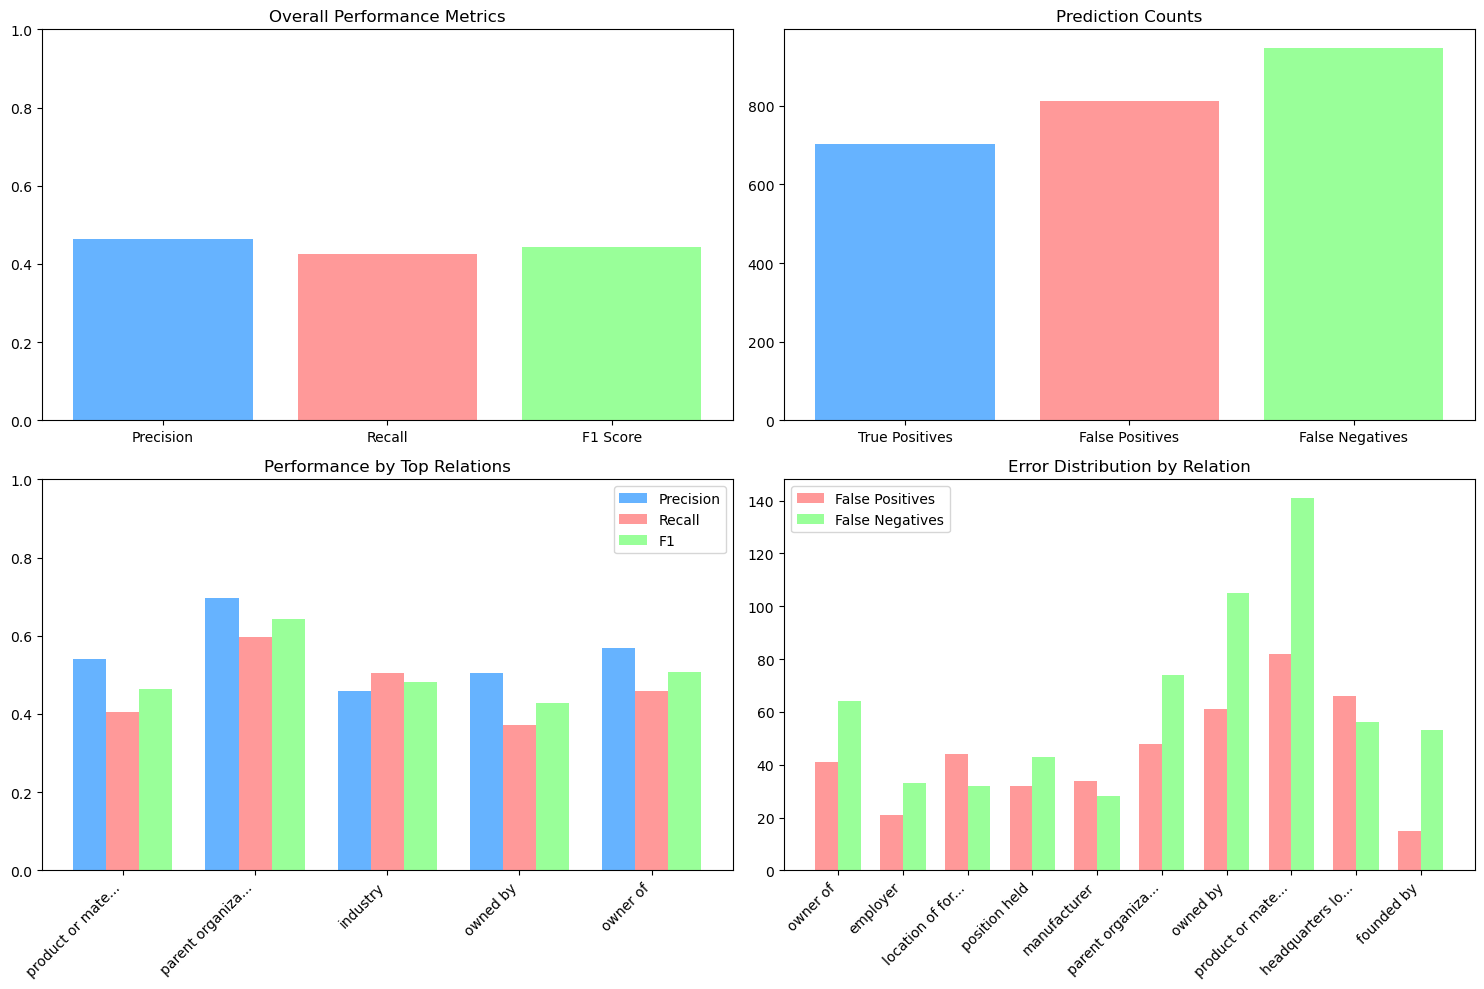


Visualization saved as 'relation_extraction_evaluation.png'


In [ ]:
# Calculate relation extraction metrics
def evaluate_relation_extraction(df, ground_truth_col='structured_annotations', prediction_col='openai_results'):
    """
    Evaluate relation extraction performance by comparing ground truth annotations with predictions.

    Parameters:
    - df: DataFrame containing both ground truth and prediction columns
    - ground_truth_col: column name containing ground truth annotations
    - prediction_col: column name containing model predictions

    Returns:
    - Dictionary with precision, recall, F1 scores, and detailed statistics
    """
    # Initialize counters
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    # For detailed analysis
    relation_metrics = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0})
    entity_pair_metrics = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0})

    # Detailed matches and errors for analysis
    matches = []
    errors = []

    # Process each row
    for idx, row in df.iterrows():
        ground_truth = row[ground_truth_col]
        predictions = row[prediction_col]

        # Skip rows with invalid data
        if not isinstance(ground_truth, set) or not isinstance(predictions, set):
            continue

        # Convert sets of tuples for comparison
        gt_triplets = set(ground_truth)  # Already normalized
        pred_triplets = set(predictions)  # Already normalized

        # Calculate true positives, false positives, and false negatives for this row
        true_positives = gt_triplets.intersection(pred_triplets)
        false_positives = pred_triplets - gt_triplets
        false_negatives = gt_triplets - pred_triplets

        # Update counters
        row_tp = len(true_positives)
        row_fp = len(false_positives)
        row_fn = len(false_negatives)

        total_true_positives += row_tp
        total_false_positives += row_fp
        total_false_negatives += row_fn

        # Record matches and errors for this row
        for triplet in true_positives:
            entity1, entity2, relation = triplet
            matches.append({
                'row_idx': idx,
                'entity1': entity1,
                'entity2': entity2,
                'relation': relation,
                'match_type': 'true_positive'
            })

            # Update relation-specific metrics
            relation_metrics[relation]['tp'] += 1

            # Update entity pair metrics
            entity_pair = f"{entity1}|{entity2}"
            entity_pair_metrics[entity_pair]['tp'] += 1

        for triplet in false_positives:
            entity1, entity2, relation = triplet
            errors.append({
                'row_idx': idx,
                'entity1': entity1,
                'entity2': entity2,
                'relation': relation,
                'error_type': 'false_positive'
            })

            # Update relation-specific metrics
            relation_metrics[relation]['fp'] += 1

            # Update entity pair metrics
            entity_pair = f"{entity1}|{entity2}"
            entity_pair_metrics[entity_pair]['fp'] += 1

        for triplet in false_negatives:
            entity1, entity2, relation = triplet
            errors.append({
                'row_idx': idx,
                'entity1': entity1,
                'entity2': entity2,
                'relation': relation,
                'error_type': 'false_negative'
            })

            # Update relation-specific metrics
            relation_metrics[relation]['fn'] += 1

            # Update entity pair metrics
            entity_pair = f"{entity1}|{entity2}"
            entity_pair_metrics[entity_pair]['fn'] += 1

    # Calculate overall precision, recall, and F1 score
    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate per-relation metrics
    relation_scores = {}
    for relation, counts in relation_metrics.items():
        rel_precision = counts['tp'] / (counts['tp'] + counts['fp']) if (counts['tp'] + counts['fp']) > 0 else 0
        rel_recall = counts['tp'] / (counts['tp'] + counts['fn']) if (counts['tp'] + counts['fn']) > 0 else 0
        rel_f1 = 2 * (rel_precision * rel_recall) / (rel_precision + rel_recall) if (rel_precision + rel_recall) > 0 else 0

        relation_scores[relation] = {
            'precision': rel_precision,
            'recall': rel_recall,
            'f1': rel_f1,
            'support': counts['tp'] + counts['fn']  # Total ground truth instances
        }

    # Return comprehensive metrics
    return {
        'overall': {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'true_positives': total_true_positives,
            'false_positives': total_false_positives,
            'false_negatives': total_false_negatives
        },
        'per_relation': relation_scores,
        'matches': matches,
        'errors': errors
    }

def print_evaluation_results(metrics):
    """Print evaluation results in a readable format"""
    overall = metrics['overall']

    print("=== OVERALL PERFORMANCE ===")
    print(f"Precision: {overall['precision']:.4f}")
    print(f"Recall: {overall['recall']:.4f}")
    print(f"F1 Score: {overall['f1']:.4f}")
    print(f"True Positives: {overall['true_positives']}")
    print(f"False Positives: {overall['false_positives']}")
    print(f"False Negatives: {overall['false_negatives']}")

    print("\n=== PERFORMANCE BY RELATION TYPE ===")
    # Sort relations by support (number of instances)
    sorted_relations = sorted(
        metrics['per_relation'].items(),
        key=lambda x: x[1]['support'],
        reverse=True
    )

    # Create a formatted table
    print(f"{'Relation':<30} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Support':<10}")
    print("-" * 70)

    for relation, scores in sorted_relations:
        print(f"{relation[:30]:<30} {scores['precision']:.4f}     {scores['recall']:.4f}     {scores['f1']:.4f}     {scores['support']}")

    # Print error analysis
    print("\n=== ERROR ANALYSIS ===")
    fp_by_relation = defaultdict(int)
    fn_by_relation = defaultdict(int)

    for error in metrics['errors']:
        if error['error_type'] == 'false_positive':
            fp_by_relation[error['relation']] += 1
        else:
            fn_by_relation[error['relation']] += 1

    print("Top False Positives by Relation:")
    for relation, count in sorted(fp_by_relation.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {relation}: {count}")

    print("\nTop False Negatives by Relation:")
    for relation, count in sorted(fn_by_relation.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {relation}: {count}")

def visualize_evaluation_results(metrics):
    """Create visualizations for evaluation results"""
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))

    # Plot 1: Overall metrics
    ax1 = fig.add_subplot(221)
    metrics_values = [metrics['overall']['precision'], metrics['overall']['recall'], metrics['overall']['f1']]
    metrics_labels = ['Precision', 'Recall', 'F1 Score']
    ax1.bar(metrics_labels, metrics_values, color=['#66b3ff', '#ff9999', '#99ff99'])
    ax1.set_ylim(0, 1)
    ax1.set_title('Overall Performance Metrics')

    # Plot 2: Confusion counts
    ax2 = fig.add_subplot(222)
    counts = [
        metrics['overall']['true_positives'],
        metrics['overall']['false_positives'],
        metrics['overall']['false_negatives']
    ]
    count_labels = ['True Positives', 'False Positives', 'False Negatives']
    ax2.bar(count_labels, counts, color=['#66b3ff', '#ff9999', '#99ff99'])
    ax2.set_title('Prediction Counts')

    # Plot 3: Top 5 relations by performance
    ax3 = fig.add_subplot(223)

    # Get top 5 relations by support
    top_relations = sorted(
        metrics['per_relation'].items(),
        key=lambda x: x[1]['support'],
        reverse=True
    )[:5]

    relation_names = [r[0] for r in top_relations]
    precision_values = [r[1]['precision'] for r in top_relations]
    recall_values = [r[1]['recall'] for r in top_relations]
    f1_values = [r[1]['f1'] for r in top_relations]

    x = np.arange(len(relation_names))
    width = 0.25

    ax3.bar(x - width, precision_values, width, label='Precision', color='#66b3ff')
    ax3.bar(x, recall_values, width, label='Recall', color='#ff9999')
    ax3.bar(x + width, f1_values, width, label='F1', color='#99ff99')

    ax3.set_xticks(x)
    ax3.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in relation_names], rotation=45, ha='right')
    ax3.set_ylim(0, 1)
    ax3.set_title('Performance by Top Relations')
    ax3.legend()

    # Plot 4: Error distribution
    ax4 = fig.add_subplot(224)

    # Count errors by type
    fp_by_relation = defaultdict(int)
    fn_by_relation = defaultdict(int)

    for error in metrics['errors']:
        if error['error_type'] == 'false_positive':
            fp_by_relation[error['relation']] += 1
        else:
            fn_by_relation[error['relation']] += 1

    # Get top relations by error count
    top_fp = sorted(fp_by_relation.items(), key=lambda x: x[1], reverse=True)[:10]
    top_fn = sorted(fn_by_relation.items(), key=lambda x: x[1], reverse=True)[:10]

    # Combine and get unique relations
    all_error_relations = set([r[0] for r in top_fp] + [r[0] for r in top_fn])
    all_error_relations = list(all_error_relations)[:10]  # Limit to top 5

    fp_counts = [fp_by_relation.get(r, 0) for r in all_error_relations]
    fn_counts = [fn_by_relation.get(r, 0) for r in all_error_relations]

    x = np.arange(len(all_error_relations))
    width = 0.35

    ax4.bar(x - width/2, fp_counts, width, label='False Positives', color='#ff9999')
    ax4.bar(x + width/2, fn_counts, width, label='False Negatives', color='#99ff99')

    ax4.set_xticks(x)
    ax4.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in all_error_relations], rotation=45, ha='right')
    ax4.set_title('Error Distribution by Relation')
    ax4.legend()

    plt.tight_layout()
    plt.savefig('relation_extraction_evaluation.png')
    plt.show()

    print("\nVisualization saved as 'relation_extraction_evaluation.png'")

# Example usage
if __name__ == "__main__":
    # Assuming you have a DataFrame with the two columns
    # Calculate metrics
    metrics = evaluate_relation_extraction(result_df)

    # Print detailed results
    print_evaluation_results(metrics)

    # Optional: Create visualizations
    visualize_evaluation_results(metrics)


=== OVERALL PERFORMANCE ===
Type: EPO | Precision: 0.3942 | Recall: 0.3582 | F1 Score: 0.3753
  True Positives: 283, False Positives: 435, False Negatives: 507
Type: SEO | Precision: 0.1028 | Recall: 0.2248 | F1 Score: 0.1411
  True Positives: 29, False Positives: 253, False Negatives: 100
Type: NEO | Precision: 0.3918 | Recall: 0.2753 | F1 Score: 0.3234
  True Positives: 201, False Positives: 312, False Negatives: 529

=== SAMPLE MATCHES ===
{'row_idx': 4, 'entity1': 'TA Associates', 'entity2': 'private equity', 'relation': 'industry', 'overlap_type': 'NEO', 'match_type': 'true_positive'}
{'row_idx': 11, 'entity1': 'Jeroen Dijsselbloem', 'entity2': 'Eurogroup', 'relation': 'position held', 'overlap_type': 'EPO', 'match_type': 'true_positive'}
{'row_idx': 11, 'entity1': 'Eurogroup', 'entity2': 'Jeroen Dijsselbloem', 'relation': 'chairperson', 'overlap_type': 'EPO', 'match_type': 'true_positive'}
{'row_idx': 14, 'entity1': '3D Systems', 'entity2': '3D printing', 'relation': 'industry', 

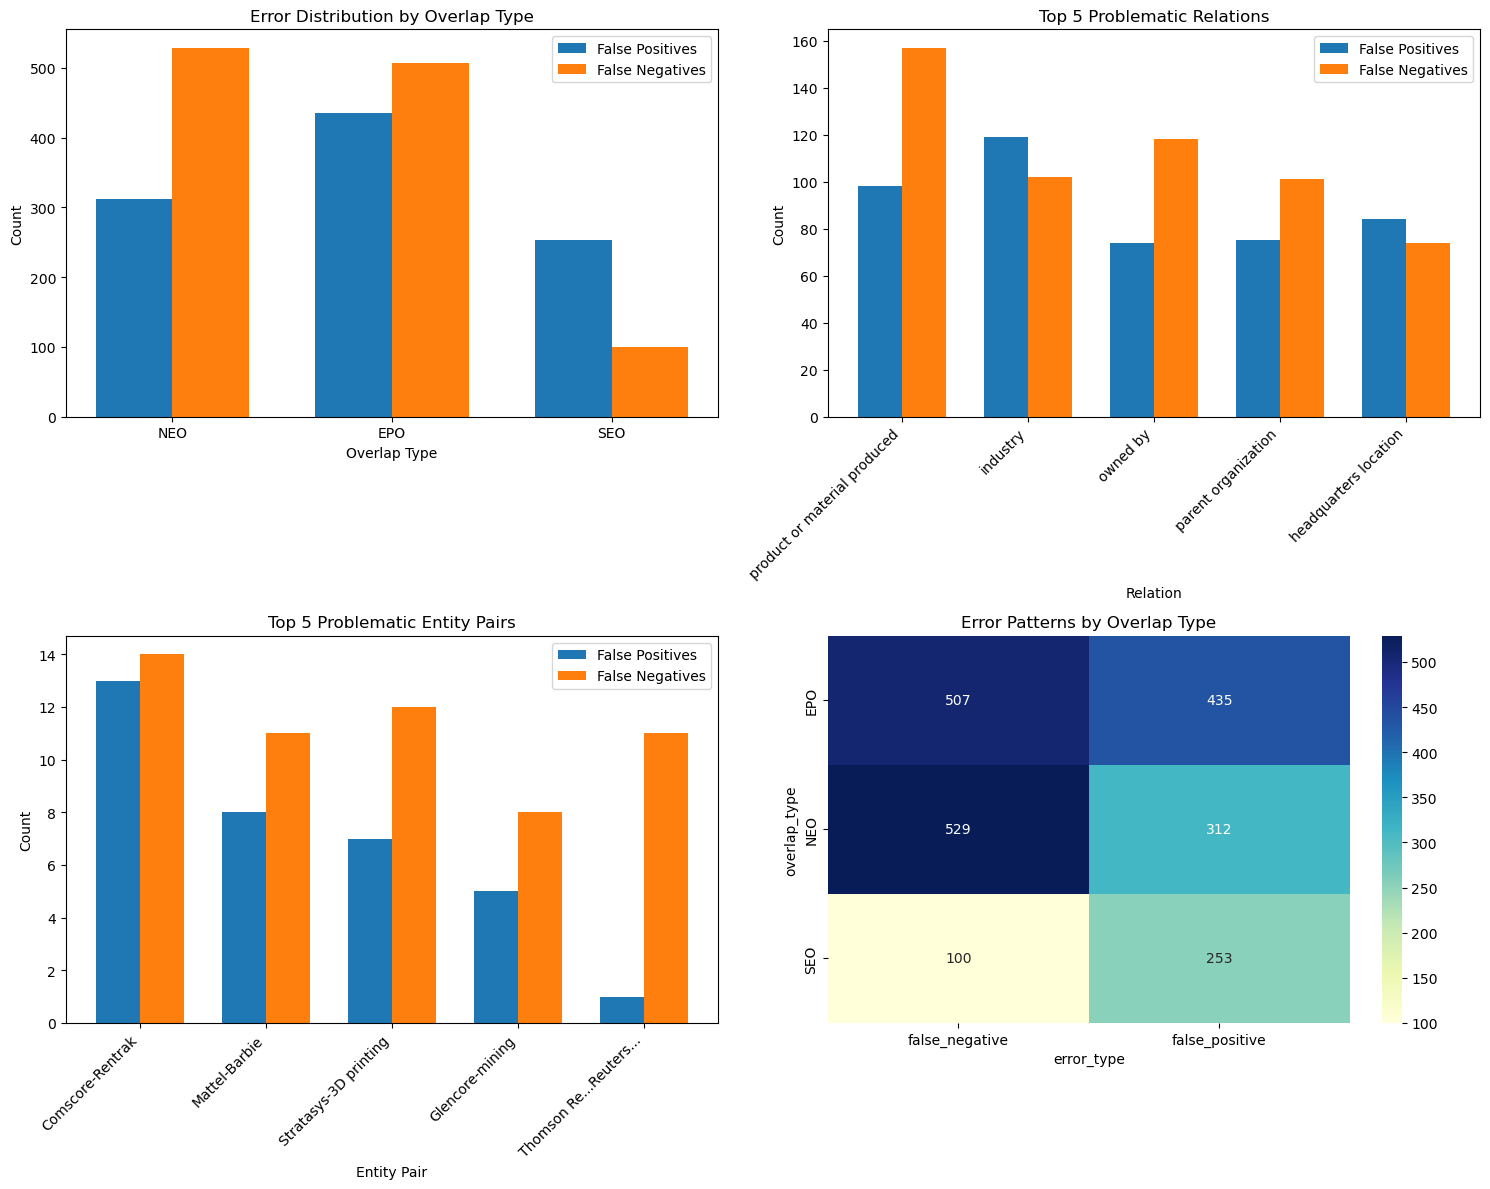

In [ ]:
# Calculate overlap extraction metrics
def evaluate_overlap_extraction(df, ground_truth_col='overlap_annotations', prediction_col='overlap_results'):
    """
    Evaluate overlap extraction performance by comparing ground truth annotations with predictions.

    Parameters:
    - df: DataFrame containing both ground truth and prediction columns
    - ground_truth_col: column name containing ground truth annotations
    - prediction_col: column name containing model predictions

    Returns:
    - Dictionary with precision, recall, F1 scores for each overlapping type, and detailed statistics
    """
    # Initialize counters for overall metrics
    total_true_positives = defaultdict(int)
    total_false_positives = defaultdict(int)
    total_false_negatives = defaultdict(int)

    # For detailed analysis
    relation_metrics = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0})

    # Detailed matches and errors for analysis
    matches = []
    errors = []

    # For error analysis
    entity_pair_errors = []
    relation_errors = []
    context_errors = []

    # Process each row
    for idx, row in df.iterrows():
        ground_truth = row[ground_truth_col]
        predictions = row[prediction_col]

        # Skip rows with invalid data
        if not isinstance(ground_truth, set) or not isinstance(predictions, set):
            continue

        # Convert sets of tuples for comparison
        gt_triplets = set(ground_truth)  # Already in the correct format
        pred_triplets = set(predictions)  # Already in the correct format

        # Calculate true positives, false positives, and false negatives for this row
        true_positives = gt_triplets.intersection(pred_triplets)
        false_positives = pred_triplets - gt_triplets
        false_negatives = gt_triplets - pred_triplets

        # Get the original text for context analysis
        text = row.get('text', '') if 'text' in row else ''

        # Update counters for each type
        for triplet in true_positives:
            entity1, entity2, relation, overlap_type = triplet
            matches.append({
                'row_idx': idx,
                'entity1': entity1,
                'entity2': entity2,
                'relation': relation,
                'overlap_type': overlap_type,
                'match_type': 'true_positive'
            })
            total_true_positives[overlap_type] += 1
            relation_metrics[overlap_type]['tp'] += 1

        for triplet in false_positives:
            entity1, entity2, relation, overlap_type = triplet
            error_info = {
                'row_idx': idx,
                'entity1': entity1,
                'entity2': entity2,
                'relation': relation,
                'overlap_type': overlap_type,
                'error_type': 'false_positive',
                'text_snippet': text[:200] + '...' if len(text) > 200 else text
            }
            errors.append(error_info)

            # Add to specialized error analysis collections
            entity_pair_errors.append((entity1, entity2, 'false_positive', overlap_type, idx))
            relation_errors.append((relation, 'false_positive', overlap_type, idx))
            context_errors.append(error_info)

            total_false_positives[overlap_type] += 1
            relation_metrics[overlap_type]['fp'] += 1

        for triplet in false_negatives:
            entity1, entity2, relation, overlap_type = triplet
            error_info = {
                'row_idx': idx,
                'entity1': entity1,
                'entity2': entity2,
                'relation': relation,
                'overlap_type': overlap_type,
                'error_type': 'false_negative',
                'text_snippet': text[:200] + '...' if len(text) > 200 else text
            }
            errors.append(error_info)

            # Add to specialized error analysis collections
            entity_pair_errors.append((entity1, entity2, 'false_negative', overlap_type, idx))
            relation_errors.append((relation, 'false_negative', overlap_type, idx))
            context_errors.append(error_info)

            total_false_negatives[overlap_type] += 1
            relation_metrics[overlap_type]['fn'] += 1

    # Calculate overall precision, recall, and F1 score for each overlap type
    overlap_scores = {}
    for overlap_type in ['EPO', 'SEO', 'NEO']:
        tp = total_true_positives[overlap_type]
        fp = total_false_positives[overlap_type]
        fn = total_false_negatives[overlap_type]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        overlap_scores[overlap_type] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': tp + fn  # Total ground truth instances
        }

    # Perform error analysis
    error_analysis = analyze_errors(entity_pair_errors, relation_errors, context_errors)

    # Return comprehensive metrics
    return {
        'overall': {
            'true_positives': total_true_positives,
            'false_positives': total_false_positives,
            'false_negatives': total_false_negatives
        },
        'per_overlap_type': overlap_scores,
        'matches': matches,
        'errors': errors,
        'error_analysis': error_analysis
    }

def analyze_errors(entity_pair_errors, relation_errors, context_errors):
    """
    Analyze errors to identify patterns and common issues.

    Parameters:
    - entity_pair_errors: List of errors with entity pair information
    - relation_errors: List of errors with relation information
    - context_errors: List of errors with context information

    Returns:
    - Dictionary with error analysis results
    """
    # Initialize error analysis results
    analysis = {
        'entity_pair_analysis': {},
        'relation_analysis': {},
        'error_distribution': {
            'by_overlap_type': defaultdict(lambda: {'fp': 0, 'fn': 0}),
            'by_error_type': defaultdict(int)
        },
        'common_error_contexts': [],
        'error_patterns': []
    }

    # Analyze entity pair errors
    entity_pair_counts = defaultdict(lambda: {'fp': 0, 'fn': 0})
    for entity1, entity2, error_type, overlap_type, _ in entity_pair_errors:
        pair_key = (entity1, entity2)
        if error_type == 'false_positive':
            entity_pair_counts[pair_key]['fp'] += 1
        else:  # false_negative
            entity_pair_counts[pair_key]['fn'] += 1

    # Find most problematic entity pairs
    problematic_pairs = sorted(
        [(pair, counts) for pair, counts in entity_pair_counts.items()],
        key=lambda x: x[1]['fp'] + x[1]['fn'],
        reverse=True
    )[:10]  # Top 10 problematic pairs

    analysis['entity_pair_analysis'] = {
        'most_problematic_pairs': problematic_pairs,
        'total_unique_pairs_with_errors': len(entity_pair_counts)
    }

    # Analyze relation errors
    relation_counts = defaultdict(lambda: {'fp': 0, 'fn': 0})
    for relation, error_type, overlap_type, _ in relation_errors:
        if error_type == 'false_positive':
            relation_counts[relation]['fp'] += 1
            analysis['error_distribution']['by_overlap_type'][overlap_type]['fp'] += 1
        else:  # false_negative
            relation_counts[relation]['fn'] += 1
            analysis['error_distribution']['by_overlap_type'][overlap_type]['fn'] += 1

        analysis['error_distribution']['by_error_type'][error_type] += 1

    # Find most problematic relations
    problematic_relations = sorted(
        [(relation, counts) for relation, counts in relation_counts.items()],
        key=lambda x: x[1]['fp'] + x[1]['fn'],
        reverse=True
    )[:10]  # Top 10 problematic relations

    analysis['relation_analysis'] = {
        'most_problematic_relations': problematic_relations,
        'total_unique_relations_with_errors': len(relation_counts)
    }

    # Analyze error patterns from context
    # Group errors by similar contexts (simplified approach)
    if context_errors:
        # Sort by overlap_type and error_type to find patterns
        sorted_context_errors = sorted(context_errors, key=lambda x: (x['overlap_type'], x['error_type']))

        # Group by overlap_type and error_type
        for (overlap_type, error_type), group in groupby(sorted_context_errors, key=lambda x: (x['overlap_type'], x['error_type'])):
            group_list = list(group)
            if len(group_list) >= 3:  # Only consider patterns with at least 3 occurrences
                pattern = {
                    'overlap_type': overlap_type,
                    'error_type': error_type,
                    'count': len(group_list),
                    'examples': group_list[:3]  # Include first 3 examples
                }
                analysis['error_patterns'].append(pattern)

    # Find common text contexts where errors occur
    # This is a simplified approach - in real-world, you might use NLP techniques
    if context_errors:
        common_contexts = []
        for error in context_errors[:50]:  # Analyze first 50 errors
            snippet = error.get('text_snippet', '')
            if snippet:
                common_contexts.append({
                    'overlap_type': error['overlap_type'],
                    'error_type': error['error_type'],
                    'entity1': error['entity1'],
                    'entity2': error['entity2'],
                    'relation': error['relation'],
                    'text_snippet': snippet
                })

        analysis['common_error_contexts'] = common_contexts[:10]  # Top 10 contexts

    return analysis

def print_overlap_evaluation_results(metrics, detailed=True, include_error_analysis=True):
    """
    Print overlap evaluation results in a readable format

    Parameters:
    - metrics: Dictionary with evaluation metrics
    - detailed: Whether to print detailed matches and errors
    - include_error_analysis: Whether to print error analysis
    """
    overall = metrics['overall']

    print("=== OVERALL PERFORMANCE ===")
    for overlap_type in ['EPO', 'SEO', 'NEO']:
        tp = overall['true_positives'][overlap_type]
        fp = overall['false_positives'][overlap_type]
        fn = overall['false_negatives'][overlap_type]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"Type: {overlap_type} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
        print(f"  True Positives: {tp}, False Positives: {fp}, False Negatives: {fn}")

    if detailed:
        # Print detailed matches and errors
        print("\n=== SAMPLE MATCHES ===")
        for match in metrics['matches'][:5]:  # Show only first 5
            print(match)

        print("\n=== SAMPLE ERRORS ===")
        for error in metrics['errors'][:5]:  # Show only first 5
            print(error)

    if include_error_analysis and 'error_analysis' in metrics:
        print_error_analysis(metrics['error_analysis'])

def print_error_analysis(error_analysis):
    """Print detailed error analysis results"""
    print("\n=== ERROR ANALYSIS ===")

    # Print error distribution by overlap type
    print("\n** Error Distribution by Overlap Type: **")
    for overlap_type, counts in error_analysis['error_distribution']['by_overlap_type'].items():
        print(f"{overlap_type}: False Positives: {counts['fp']}, False Negatives: {counts['fn']}")

    # Print most problematic entity pairs
    print("\n** Most Problematic Entity Pairs: **")
    for (entity1, entity2), counts in error_analysis['entity_pair_analysis']['most_problematic_pairs'][:5]:
        print(f"'{entity1}' - '{entity2}': False Positives: {counts['fp']}, False Negatives: {counts['fn']}")

    # Print most problematic relations
    print("\n** Most Problematic Relations: **")
    for relation, counts in error_analysis['relation_analysis']['most_problematic_relations'][:5]:
        print(f"'{relation}': False Positives: {counts['fp']}, False Negatives: {counts['fn']}")

    # Print error patterns
    print("\n** Error Patterns: **")
    for pattern in error_analysis['error_patterns'][:3]:
        print(f"Pattern: {pattern['overlap_type']} - {pattern['error_type']} (Count: {pattern['count']})")
        print(f"  Example: {pattern['examples'][0]['entity1']} - {pattern['examples'][0]['entity2']} - {pattern['examples'][0]['relation']}")

    # Print common error contexts
    print("\n** Sample Error Contexts: **")
    for context in error_analysis['common_error_contexts'][:3]:
        print(f"Error Type: {context['error_type']} for {context['overlap_type']}")
        print(f"  Entities: {context['entity1']} - {context['entity2']}, Relation: {context['relation']}")
        print(f"  Context: {context['text_snippet'][:100]}...")

def visualize_error_analysis(metrics, save_path=None):
    """
    Create visualizations for error analysis

    Parameters:
    - metrics: Dictionary with evaluation metrics including error analysis
    - save_path: Path to save the visualizations (if None, displays them)
    """
    if 'error_analysis' not in metrics:
        print("Error analysis data not available for visualization")
        return

    error_analysis = metrics['error_analysis']

    # Set up the figure layout
    plt.figure(figsize=(15, 12))

    # 1. Overlap Type Distribution
    plt.subplot(2, 2, 1)
    overlap_types = []
    fp_counts = []
    fn_counts = []

    for overlap_type, counts in error_analysis['error_distribution']['by_overlap_type'].items():
        overlap_types.append(overlap_type)
        fp_counts.append(counts['fp'])
        fn_counts.append(counts['fn'])

    x = range(len(overlap_types))
    width = 0.35

    plt.bar([i - width/2 for i in x], fp_counts, width, label='False Positives')
    plt.bar([i + width/2 for i in x], fn_counts, width, label='False Negatives')
    plt.xlabel('Overlap Type')
    plt.ylabel('Count')
    plt.title('Error Distribution by Overlap Type')
    plt.xticks(x, overlap_types)
    plt.legend()

    # 2. Top Problematic Relations
    plt.subplot(2, 2, 2)
    relations = []
    relation_fp = []
    relation_fn = []

    for relation, counts in error_analysis['relation_analysis']['most_problematic_relations'][:5]:
        relations.append(relation)
        relation_fp.append(counts['fp'])
        relation_fn.append(counts['fn'])

    x = range(len(relations))

    plt.bar([i - width/2 for i in x], relation_fp, width, label='False Positives')
    plt.bar([i + width/2 for i in x], relation_fn, width, label='False Negatives')
    plt.xlabel('Relation')
    plt.ylabel('Count')
    plt.title('Top 5 Problematic Relations')
    plt.xticks(x, relations, rotation=45, ha='right')
    plt.legend()

    # 3. Top Problematic Entity Pairs
    plt.subplot(2, 2, 3)
    entity_pairs = []
    pair_fp = []
    pair_fn = []

    for (entity1, entity2), counts in error_analysis['entity_pair_analysis']['most_problematic_pairs'][:5]:
        entity_pairs.append(f"{entity1[:10]}...{entity2[:10]}..." if len(entity1) + len(entity2) > 20 else f"{entity1}-{entity2}")
        pair_fp.append(counts['fp'])
        pair_fn.append(counts['fn'])

    x = range(len(entity_pairs))

    plt.bar([i - width/2 for i in x], pair_fp, width, label='False Positives')
    plt.bar([i + width/2 for i in x], pair_fn, width, label='False Negatives')
    plt.xlabel('Entity Pair')
    plt.ylabel('Count')
    plt.title('Top 5 Problematic Entity Pairs')
    plt.xticks(x, entity_pairs, rotation=45, ha='right')
    plt.legend()

    # 4. Error Patterns by Overlap Type
    plt.subplot(2, 2, 4)
    # Extract pattern data
    pattern_data = []
    for pattern in error_analysis['error_patterns']:
        pattern_data.append({
            'overlap_type': pattern['overlap_type'],
            'error_type': pattern['error_type'],
            'count': pattern['count']
        })

    if pattern_data:
        # Convert to DataFrame for easier visualization
        import pandas as pd
        pattern_df = pd.DataFrame(pattern_data)

        # Create a pivot table
        pivot_table = pattern_df.pivot_table(
            index='overlap_type',
            columns='error_type',
            values='count',
            aggfunc='sum',
            fill_value=0
        )

        # Plot as heatmap
        sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt="d")
        plt.title('Error Patterns by Overlap Type')
    else:
        plt.text(0.5, 0.5, 'No pattern data available', ha='center', va='center')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage
if __name__ == "__main__":
    # Assuming you have a DataFrame with the two columns
    # Calculate metrics
    metrics = evaluate_overlap_extraction(result_df)

    # Print detailed results
    print_overlap_evaluation_results(metrics)

    # Create visualizations
    visualize_error_analysis(metrics, save_path="overlap_error_analysis.png")


In [ ]:
# Calculate mutlti-triplets extraction metrics
def evaluate_relation_extraction_with_multi(df,
                                           structured_col='structured_annotations',
                                           openai_col='openai_results',
                                           multi_col='multi_annotations',
                                           text_col=None):  # Optional text column for error analysis
    """
    Evaluate relation extraction performance by comparing ground truth annotations with predictions
    while categorizing by the number of multi-triplets.

    Parameters:
    - df: DataFrame containing ground truth, predictions, and multi-triplet counts
    - structured_col: column name containing ground truth annotations
    - openai_col: column name containing model predictions
    - multi_col: column name containing counts of multi-triplets
    - text_col: optional column name containing original text for error analysis

    Returns:
    - Dictionary with precision, recall, F1 scores, accuracy, detailed statistics, and error analysis
    """
    # Initialize counters for overall metrics
    metrics_by_category = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0, 'count': 0, 'matching': 0})
    total_correct_triplets = 0
    total_triplet_counts = 0

    # Initialize counters for multi-triplet accuracy
    total_matching_triplets = 0
    total_triplet_labels = 0

    # Initialize error analysis structures
    error_analysis = {
        'relation_errors': defaultdict(int),  # Count errors by relation type
        'entity_errors': defaultdict(int),    # Count errors by entity type
        'error_examples': [],                 # Store examples of errors for qualitative analysis
        'error_types': {
            'missing_relation': 0,            # Complete relation missing
            'incorrect_relation': 0,          # Relation type is wrong
            'entity_boundary': 0,             # Entity span is incorrect
            'entity_type': 0,                 # Entity type is incorrect
            'swapped_entities': 0,            # Subject and object are swapped
            'extra_relation': 0,              # Model predicted relation not in ground truth
            'multi_triplet_count': 0          # Wrong number of triplets predicted
        }
    }

    # Process each row
    for idx, row in df.iterrows():
        ground_truth = row[structured_col]
        predictions = row[openai_col]
        multi_triplet_count = row[multi_col]
        original_text = row[text_col] if text_col else None

        # Skip rows with invalid data
        if not isinstance(ground_truth, set) or not isinstance(predictions, set):
            continue

        # Convert sets of tuples for comparison
        gt_triplets = set(ground_truth)  # Already normalized
        pred_triplets = set(predictions)  # Already normalized

        # Calculate true positives, false positives, and false negatives for this row
        true_positives = gt_triplets.intersection(pred_triplets)
        false_positives = pred_triplets - gt_triplets
        false_negatives = gt_triplets - pred_triplets

        # Update metrics based on the multi-triplet count
        if multi_triplet_count == 1:
            category = '1 multi-triplet'
        elif multi_triplet_count == 2:
            category = '2 multi-triplets'
        elif multi_triplet_count == 3:
            category = '3 multi-triplets'
        elif multi_triplet_count == 4:
            category = '4 multi-triplets'
        else:
            category = '5+ multi-triplets'

        metrics_by_category[category]['tp'] += len(true_positives)
        metrics_by_category[category]['fp'] += len(false_positives)
        metrics_by_category[category]['fn'] += len(false_negatives)
        metrics_by_category[category]['count'] += 1  # Count of rows in this category

        # Calculate accuracy for triplet counts
        total_correct_triplets += len(pred_triplets) if len(pred_triplets) == multi_triplet_count else 0
        total_triplet_counts += multi_triplet_count

        # Calculate accuracy for multi-triplet counts
        total_matching_triplets += 1 if len(pred_triplets) == multi_triplet_count else 0
        total_triplet_labels += 1

        # Update matching count for the category
        if len(pred_triplets) == multi_triplet_count:
            metrics_by_category[category]['matching'] += 1
        else:
            error_analysis['error_types']['multi_triplet_count'] += 1

        # Perform detailed error analysis
        analyze_errors(gt_triplets, pred_triplets, error_analysis, idx, original_text)

    # Calculate precision, recall, and F1 score for each category
    category_scores = {}
    for category, counts in metrics_by_category.items():
        tp = counts['tp']
        fp = counts['fp']
        fn = counts['fn']

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        category_scores[category] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': counts['count'],  # Number of rows in this category
            'matching': counts['matching']  # Count of matching triplet predictions
        }

    # Calculate accuracy
    accuracy = total_correct_triplets / total_triplet_counts if total_triplet_counts > 0 else 0
    triplet_accuracy = total_matching_triplets / total_triplet_labels if total_triplet_labels > 0 else 0

    # Return comprehensive metrics
    return {
        'category_scores': category_scores,
        'accuracy': accuracy,
        'triplet_accuracy': triplet_accuracy,
        'error_analysis': error_analysis
    }

def analyze_errors(gt_triplets, pred_triplets, error_analysis, idx, original_text=None):
    """
    Perform detailed error analysis on false positives and false negatives.

    Parameters:
    - gt_triplets: set of ground truth triplets
    - pred_triplets: set of predicted triplets
    - error_analysis: dictionary to store error analysis results
    - idx: index of the current row for reference
    - original_text: original text for context (if available)
    """
    # Analyze false negatives (relations in ground truth but not in predictions)
    for triplet in gt_triplets - pred_triplets:
        subj, rel, obj = triplet
        error_analysis['relation_errors'][rel] += 1

        # Check if a similar triplet exists with incorrect relation
        for p_triplet in pred_triplets:
            p_subj, p_rel, p_obj = p_triplet

            # Check for relation type errors
            if p_subj == subj and p_obj == obj and p_rel != rel:
                error_analysis['error_types']['incorrect_relation'] += 1
                break

            # Check for entity boundary or type errors
            elif similar_entities(p_subj, subj) and p_obj == obj and p_rel == rel:
                error_analysis['error_types']['entity_boundary'] += 1
                error_analysis['entity_errors'][f"subj:{get_entity_type(subj)}"] += 1
                break
            elif p_subj == subj and similar_entities(p_obj, obj) and p_rel == rel:
                error_analysis['error_types']['entity_boundary'] += 1
                error_analysis['entity_errors'][f"obj:{get_entity_type(obj)}"] += 1
                break

            # Check for swapped entities
            elif p_subj == obj and p_obj == subj and p_rel == rel:
                error_analysis['error_types']['swapped_entities'] += 1
                break
        else:
            # If no similar triplet was found, it's a completely missing relation
            error_analysis['error_types']['missing_relation'] += 1

        # Store examples of errors for qualitative analysis (limit to 10 examples per type)
        if len(error_analysis['error_examples']) < 100:
            error_example = {
                'type': 'false_negative',
                'index': idx,
                'ground_truth': triplet,
                'text': original_text
            }
            error_analysis['error_examples'].append(error_example)

    # Analyze false positives (relations in predictions but not in ground truth)
    for triplet in pred_triplets - gt_triplets:
        subj, rel, obj = triplet
        error_analysis['relation_errors'][rel] += 1
        error_analysis['error_types']['extra_relation'] += 1

        # Store examples of errors for qualitative analysis
        if len(error_analysis['error_examples']) < 100:
            error_example = {
                'type': 'false_positive',
                'index': idx,
                'prediction': triplet,
                'text': original_text
            }
            error_analysis['error_examples'].append(error_example)

def similar_entities(entity1, entity2):
    """
    Check if two entities are similar (partial overlap or type mismatch).
    This is a simplified version - you might want to implement more sophisticated matching.

    Parameters:
    - entity1, entity2: entity strings to compare

    Returns:
    - Boolean indicating if entities are similar
    """
    # Simplified check - you can implement more sophisticated matching
    if isinstance(entity1, str) and isinstance(entity2, str):
        # Check for partial string overlap
        if entity1 in entity2 or entity2 in entity1:
            return True

        # Check if they differ only by entity type marker
        entity1_text = entity1.split(':')[-1] if ':' in entity1 else entity1
        entity2_text = entity2.split(':')[-1] if ':' in entity2 else entity2
        if entity1_text == entity2_text:
            return True

    return False

def get_entity_type(entity):
    """Extract entity type from entity string if available"""
    if isinstance(entity, str) and ':' in entity:
        return entity.split(':')[0]
    return "unknown"

def print_multi_evaluation_results(metrics):
    """Print evaluation results for multi-triplet categories in a readable format"""
    print("=== PERFORMANCE BY MULTI-TRIPLET CATEGORY ===")
    print(f"{'Category':<25} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Support':<10} {'Matching':<10}")
    print("-" * 80)

    # Sort categories by the numerical part in ascending order
    sorted_categories = sorted(metrics['category_scores'].items(),
                               key=lambda x: (int(x[0].split()[0]) if '+' not in x[0] else float('inf')))

    for category, scores in sorted_categories:
        print(f"{category:<25} {scores['precision']:.4f}     {scores['recall']:.4f}     {scores['f1']:.4f}     {scores['support']}     {scores['matching']}")

    # Print overall accuracy
    print(f"\nOverall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Triplet Count Accuracy: {metrics['triplet_accuracy']:.4f}")

    # Print error analysis
    print_error_analysis(metrics['error_analysis'])

def print_error_analysis(error_analysis):
    """Print detailed error analysis results"""
    print("\n=== ERROR ANALYSIS ===")

    # Print error types distribution
    print("\n** Error Types Distribution: **")
    total_errors = sum(error_analysis['error_types'].values())
    for error_type, count in sorted(error_analysis['error_types'].items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total_errors * 100) if total_errors > 0 else 0
        print(f"{error_type:<20}: {count} ({percentage:.2f}%)")

    # Print most common relation errors
    print("\n** Most Common Relation Errors: **")
    for relation, count in sorted(error_analysis['relation_errors'].items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{relation:<30}: {count}")

    # Print most common entity errors
    print("\n** Most Common Entity Type Errors: **")
    for entity, count in sorted(error_analysis['entity_errors'].items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{entity:<20}: {count}")

    # Print error examples (limited to 5 for readability)
    print("\n** Error Examples: **")
    for i, example in enumerate(error_analysis['error_examples'][:5]):
        print(f"\nExample {i+1} (Index: {example['index']}, Type: {example['type']})")
        if 'ground_truth' in example:
            print(f"Ground Truth: {example['ground_truth']}")
        if 'prediction' in example:
            print(f"Prediction: {example['prediction']}")
        if example['text']:
            print(f"Text: {example['text'][:100]}..." if len(example['text']) > 100 else f"Text: {example['text']}")
        print("-" * 40)

# Example usage
if __name__ == "__main__":
    # Assuming you have a DataFrame with the appropriate columns
    metrics = evaluate_relation_extraction_with_multi(result_df, text_col='text')

    # Print detailed results
    print_multi_evaluation_results(metrics)


=== PERFORMANCE BY MULTI-TRIPLET CATEGORY ===
Category                  Precision  Recall     F1         Support    Matching  
--------------------------------------------------------------------------------
1 multi-triplet           0.3691     0.4488     0.4051     713     379
2 multi-triplets          0.5590     0.4545     0.5014     198     94
3 multi-triplets          0.5860     0.4118     0.4837     102     20
4 multi-triplets          0.6705     0.3352     0.4470     44     4
5+ multi-triplets         0.8095     0.2931     0.4304     11     0

Overall Accuracy: 0.3899
Triplet Count Accuracy: 0.4654

=== ERROR ANALYSIS ===

** Error Types Distribution: **
missing_relation    : 865 (37.14%)
extra_relation      : 811 (34.82%)
multi_triplet_count : 571 (24.52%)
incorrect_relation  : 56 (2.40%)
entity_boundary     : 26 (1.12%)
entity_type         : 0 (0.00%)
swapped_entities    : 0 (0.00%)

** Most Common Relation Errors: **
London                        : 51
Google                   